# Preliminary

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
import sys

import numpy as np
import pickle, random, string
import matplotlib.pyplot as plt
%matplotlib inline

# Visualization
from IPython.display import display

from pathlib import Path

In [2]:
# Ugly patch becasue idk how to make this propperly work
#sys.path[0] += '/Codebase'
sys.path

['/home/jovyan/Extrapolation-Exploration/Codebase',
 '/opt/conda/lib/python39.zip',
 '/opt/conda/lib/python3.9',
 '/opt/conda/lib/python3.9/lib-dynload',
 '',
 '/opt/conda/lib/python3.9/site-packages']

In [3]:
#my classes
#from testClass import *
from transformerClasses import *
from embeddingClasses import *
from lstmClasses import *
from resourceFunctions import *

2022-08-09 16:48:59.651571: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-09 16:48:59.651609: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-09 16:48:59.651636: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-lak3r): /proc/driver/nvidia/version does not exist
2022-08-09 16:48:59.651994: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
strategy = tf.distribute.OneDeviceStrategy('gpu:1')

# Loading Outer Model???

In [5]:
# setting up the pathlib stuff 
path = Path('..')
print([x for x in path.iterdir() if x.is_dir()])

path = path / 'saved-models'
outPath = path / 'outer_encdec_intembed'

encPathJson = outPath / 'encoder_len5_J_10000_intembed.json'
decPathJson = outPath / 'decoder_len5_J_10000_intembed.json'
encPathH5 = outPath / 'encoder_len5_J_10000_intembed.h5'
decPathH5 = outPath / 'decoder_len5_J_10000_intembed.h5'

[PosixPath('../.ipynb_checkpoints'), PosixPath('../saved-models'), PosixPath('../Qualifying-Exam-Writings'), PosixPath('../Codebase'), PosixPath('../Papers'), PosixPath('../data'), PosixPath('../.git')]


In [6]:
with encPathJson.open() as encoder_file, decPathJson.open() as decoder_file:
    encoder_json = encoder_file.read()
    decoder_json = decoder_file.read()
outer_encoder = keras.models.model_from_json(encoder_json)
outer_decoder = keras.models.model_from_json(decoder_json)
outer_encoder.load_weights(encPathH5)
outer_decoder.load_weights(decPathH5)

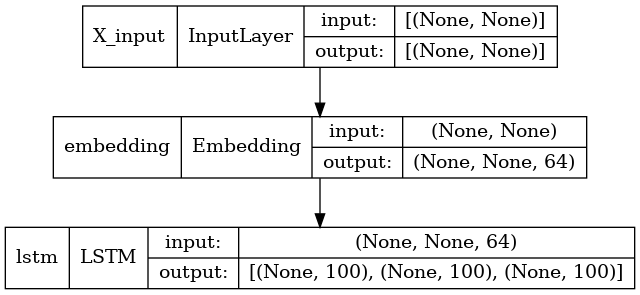

In [7]:
keras.utils.plot_model(outer_encoder, show_shapes=True)

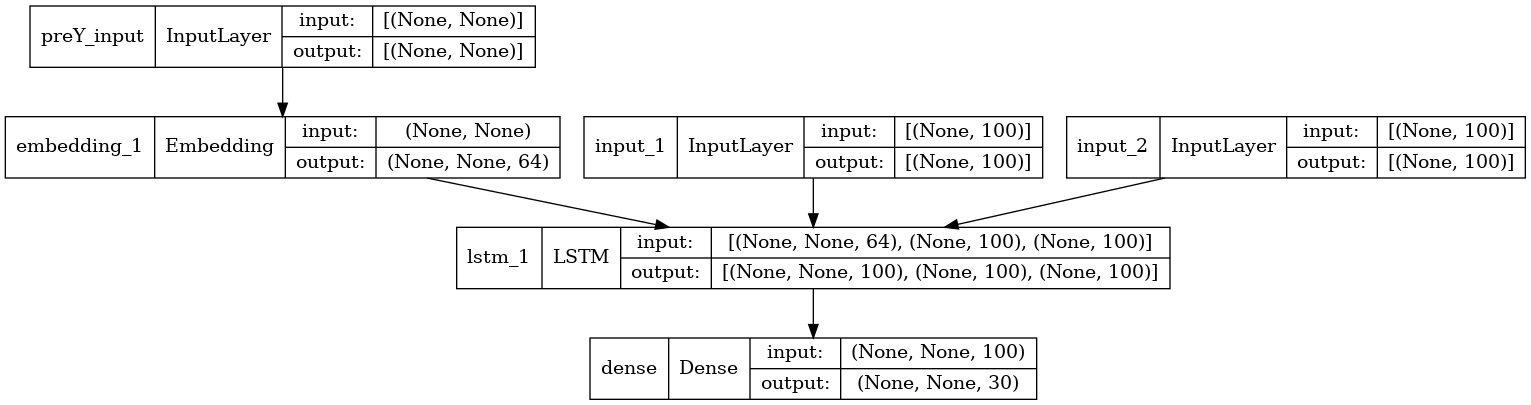

In [8]:
keras.utils.plot_model(outer_decoder, show_shapes=True)

# Load Input Data ???

In [9]:
# corpus = np.loadtxt(sys.argv[1], dtype=object) #open('../thesis-master/data/len5_10000-train.txt')#
# trainingSet = np.loadtxt(sys.argv[2], dtype=object) #open('../thesis-master/data/SG-10-train.txt')
# testingSet  = np.loadtxt(sys.argv[3], dtype=object)#open('../thesis-master/data/SG-10-test.txt')

In [10]:
corpus = open('../data/len5_10000-train.txt')#corpus = np.loadtxt(sys.argv[1], dtype=object)
corpus = np.loadtxt(corpus, dtype=object)

trainingSet = open('../data/SG-10-train.txt')
testingSet  = open('../data/SG-10-test.txt')

trainingSet = np.loadtxt(trainingSet, dtype=str)
testingSet  = np.loadtxt(testingSet, dtype=str)

#Do note that I'm not confident in this

In [11]:
# --- Create a dictionary for all the letters & start/stops ---
alphabet = np.array([i for i in range(1, 31)]) # All letters plus STARTSENTENCE, STOPSENTENCE, start, stop
mapping = dict()
for i in range(len(alphabet) - 4):
    mapping[chr(ord('a') + i)] = alphabet[i]

mapping['start'] = alphabet[26]
mapping['stop']  = alphabet[27]
mapping['STARTSETNENCE'] = alphabet[28]
mapping['STOPSENTENCE']  = alphabet[29]

In [12]:
# --- Map words from corpus to words to roles ---
encoded_mapping = {}
selected_words = {}
for letter in string.ascii_lowercase[:10]:
    # Store the letter with the word for use in testing
    rand_corpus_word = random.choice(corpus)

    word, Y, preY, postY = word_to_int(rand_corpus_word, mapping)
    
    selected_words[letter] = postY
    
    encoded_mapping[letter] = outer_encoder.predict(np.array([word]))

In [13]:
#--- Pre input to make encodings at the sentence level --- 
roles   = trainingSet #argv[2]    
x_train = []
for sentence in roles:
    x_train.append([encoded_mapping[letter] for letter in sentence])
x_train = np.array(x_train) # shape (n, 3, 2, 1, 50)

LENGTH_IDK  = x_train.shape[-1] # Replacing '50' in the code

t1 = x_train[:,:,0,0,:] # new shape (n,3,50)
t2 = x_train[:,:,1,0,:] # " '' "
# 4 time steps. pre
pre_t1 = np.concatenate((np.zeros((x_train.shape[0],1,LENGTH_IDK)), t1), axis = 1) # Orig. (x_train.shape[0], 1, 50)
pre_t2 = np.concatenate((np.zeros((x_train.shape[0],1,LENGTH_IDK)), t2), axis = 1)
post_t1 = np.concatenate((t1, np.zeros((x_train.shape[0],1,LENGTH_IDK))), axis = 1)
post_t2 = np.concatenate((t2, np.zeros((x_train.shape[0],1,LENGTH_IDK))), axis = 1)

In [14]:
# Start or stop tokens
s_s = {"start": [0,1], "stop": [1,0], "none": [0,0]}
pre_t3 = np.zeros((x_train.shape[0], 4, 2))
post_t3 = np.copy(pre_t3)
pre_t3[:,0,:] = s_s["start"]
post_t3[:,3,:] = s_s["stop"]

# Inner LSTM ???

In [15]:
# --- Set hyperparameters ---
HIDDEN_SIZE = 300
BATCH_SIZE  = 100
EPOCHS      = 1600

with strategy.scope():
    # --- Construct inner encoder/decoder ---
    encoder_input_t1 = keras.layers.Input(shape=(None, t1.shape[2]), name="enc_token_1")
    encoder_input_t2 = keras.layers.Input(shape=(None, t1.shape[2]), name="enc_token_2")
    encoder_input = keras.layers.Concatenate()([encoder_input_t1, encoder_input_t2])

    encoder_hidden = keras.layers.LSTM(HIDDEN_SIZE, return_state=True, name="FUTURE_TRANSFORMER")
    # Tie them together
    encoder_output, enc_state_h, enc_state_c = encoder_hidden(encoder_input)
    # Don't need the encoder outputs, just need the states.
    encoder_states = [enc_state_h, enc_state_c]

    decoder_input_t1 = keras.layers.Input(shape=(None, t1.shape[2]), name="dec_token_1")
    decoder_input_t2 = keras.layers.Input(shape=(None, t1.shape[2]), name="dec_token_2")
    decoder_input_t3 = keras.layers.Input(shape=(None, 2), name="dec_start/stop")
    decoder_input = keras.layers.Concatenate()([decoder_input_t1, decoder_input_t2, decoder_input_t3])

    decoder_hidden = keras.layers.LSTM(HIDDEN_SIZE, return_sequences=True, return_state=True, name="FUTURE_MASKED_TRANSFORMER")
    # Tie it together
    decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                             initial_state=encoder_states)
    decoder_dense_t1 = keras.layers.Dense(t1.shape[2], activation='linear', name="token_1")
    decoder_dense_t2 = keras.layers.Dense(t1.shape[2], activation='linear', name="token_2")
    decoder_dense_t3 = keras.layers.Dense(2, activation='sigmoid', name="start/stop")
    # Connect output to hidden
    decoder_output = [decoder_dense_t1(decoder_hidden_output), decoder_dense_t2(decoder_hidden_output), decoder_dense_t3(decoder_hidden_output)]

    model = keras.Model([encoder_input_t1, encoder_input_t2, decoder_input_t1, decoder_input_t2, decoder_input_t3], decoder_output)

    model.compile(loss = [keras.losses.MSE, keras.losses.MSE, keras.losses.binary_crossentropy],
                   optimizer=keras.optimizers.Adam(),
                   metrics=['accuracy'])

    model_input = {"enc_token_1": t1, "enc_token_2": t2, "dec_token_1": pre_t1, "dec_token_2": pre_t2, "dec_start/stop": pre_t3}
    model_target = {"token_1": post_t1, "token_2": post_t2, "start/stop": post_t3}

    # --- Train model ---
    history = model.fit(model_input, model_target,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=0)
    #accuracy = model.evaluate(model_input, model_target) # use `model.metrics_names` to get indices for accuracy:



2022-08-09 16:49:01.398016: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_3287"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:134"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 100
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. Y

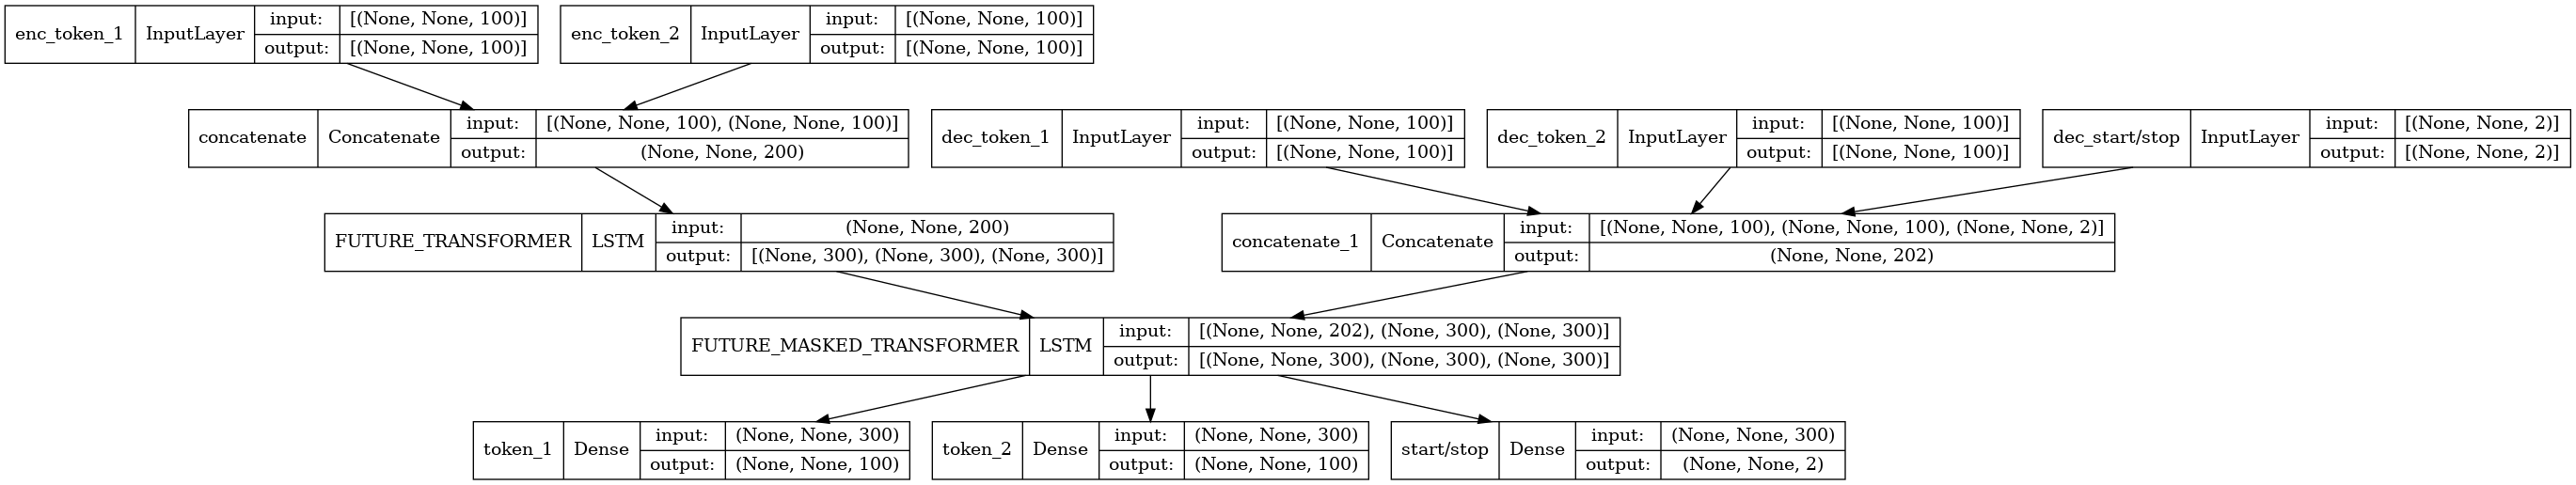

In [16]:
keras.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [17]:
with strategy.scope():
    
    # --- Restructure the model without teacher forcing ---
    encoder_model = keras.Model([encoder_input_t1, encoder_input_t2], encoder_states)

    # Decoder
    decoder_state_input_h = keras.layers.Input(shape=(HIDDEN_SIZE,), name="states_input_h")
    decoder_state_input_c = keras.layers.Input(shape=(HIDDEN_SIZE,), name="states_input_c")
    # inputs to hidden
    decoder_states_input = [decoder_state_input_h, decoder_state_input_c]
    decoder_hidden_output, decoder_state_h, decoder_state_c = decoder_hidden(decoder_input,
                                                                             initial_state=decoder_states_input)
    decoder_states = [decoder_state_h, decoder_state_c]
    # hidden to outputs

    decoder_output = [decoder_dense_t1(decoder_hidden_output), decoder_dense_t2(decoder_hidden_output), decoder_dense_t3(decoder_hidden_output)]
    decoder_model = keras.Model(
        [decoder_input_t1, decoder_input_t2, decoder_input_t3] + decoder_states_input,
        decoder_output + decoder_states)



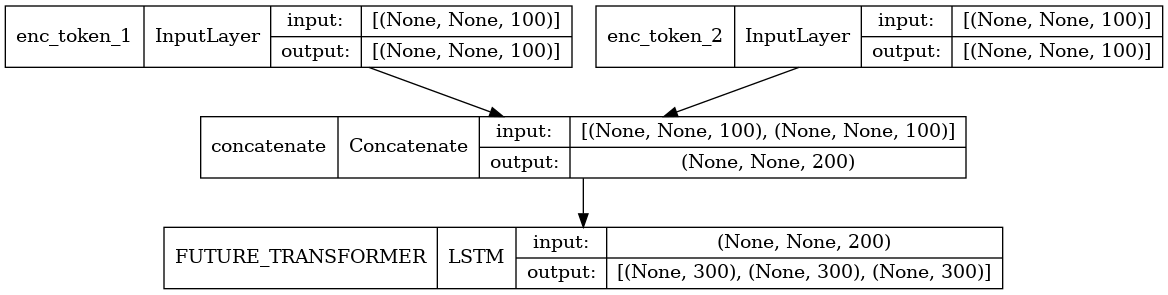

In [21]:
keras.utils.plot_model(encoder_model, expand_nested=True, show_shapes=True)

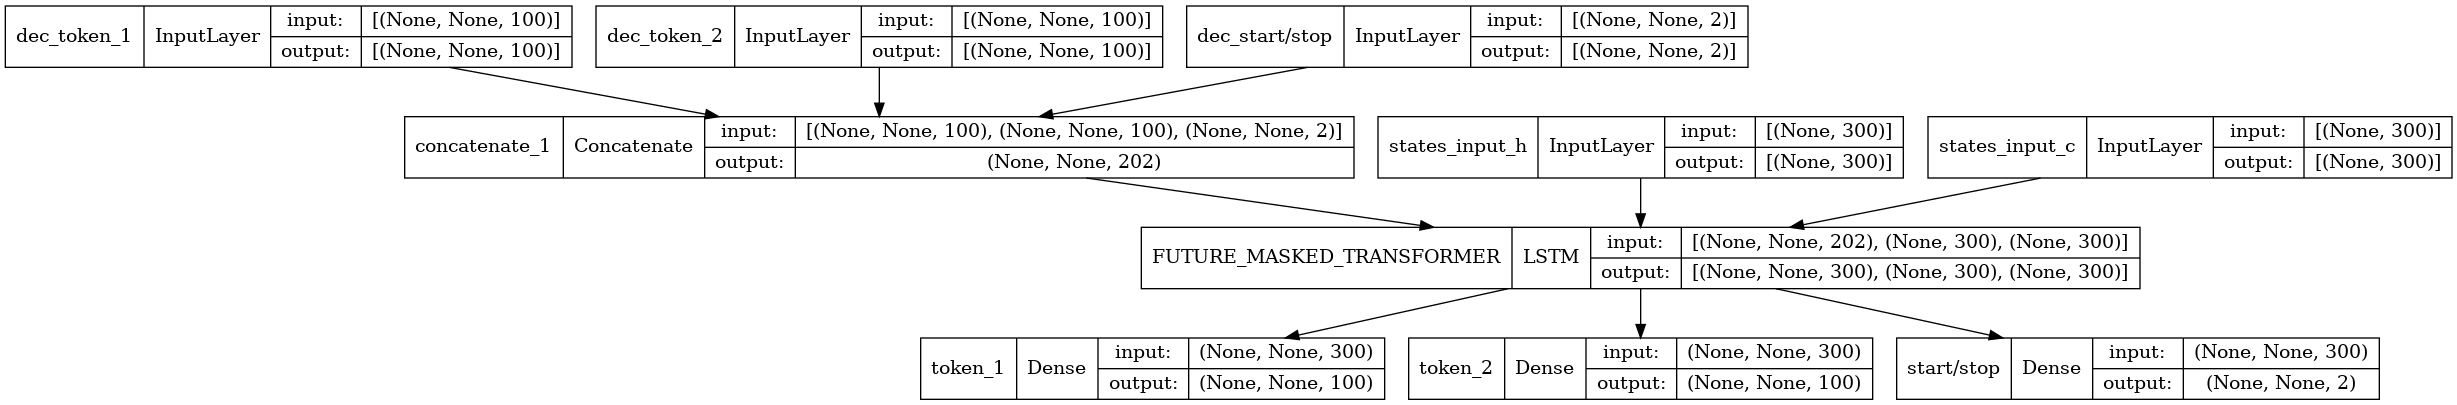

In [22]:
keras.utils.plot_model(decoder_model, expand_nested=True, show_shapes=True)

In [23]:
with strategy.scope():
    # --- Extract the model's output from inner then outer decoder ---
    x_test = []
    correct_result = [] # used to get accuracy at end
    roles = testingSet #argv[3]
    for sentence in roles:
        x_test.append([encoded_mapping[letter] for letter in sentence])
        correct_result.append([selected_words[letter] for letter in sentence])

    x_test = np.array(x_test) # shape (n, 3, 2, 1, 50)
    correct_result = np.array(correct_result)

    t1 = x_test[:,:,0,0,:] # new shape (n,3,50)
    t2 = x_test[:,:,1,0,:] # " '' "
    # 4 time steps. pre
    pre_t1 = np.concatenate((np.zeros((x_test.shape[0],1,LENGTH_IDK)), t1), axis = 1)
    pre_t2 = np.concatenate((np.zeros((x_test.shape[0],1,LENGTH_IDK)), t2), axis = 1)

    # Start tokens
    pre_t3 = np.zeros((x_test.shape[0], 4, 2))
    pre_t3[:,0,:] = s_s["start"]

    outer_result = np.empty((len(x_test),3,6))

    
    for i, sentence in enumerate(x_test):
        context = encoder_model.predict({"enc_token_1": t1[i:i+1], "enc_token_2": t2[i:i+1]})
        print(context)
        dec_t1 = np.zeros((1,1,LENGTH_IDK))
        dec_t2 = np.zeros((1,1,LENGTH_IDK))
        dec_s_s = pre_t3[0:1,0:1,:]
        inner_result = np.zeros([4,2,LENGTH_IDK])
        output_length = 3

        # obtain the result from the inner decoder
        for x in range(output_length+1):
            out1, out2, out3, h, c = decoder_model.predict({"states_input_h": context[0], 
                                             "states_input_c": context[1],
                                             "dec_token_1": dec_t1,
                                             "dec_token_2": dec_t2,
                                             "dec_start/stop": dec_s_s})
            context = [h,c]
            dec_t1 = out1
            dec_t2 = out2
            dec_s_s = out3
            inner_result[x,0,:] = out1
            inner_result[x,1,:] = out2

        # obtain the result from the outer decoder
        output_length = 5
        for word in range(3):
            context = []
            context.append(inner_result[word,0:1,:])
            context.append(inner_result[word,1:2,:])
            token = np.array(mapping["start"])
            token = token.reshape([1, 1, 1])
            for letter in range(output_length + 1):
                out, h, c = outer_decoder.predict([token] + context)
                token = Out_to_int(out)
                context = [h,c]
                outer_result[i, word, letter] = token

2022-08-09 17:04:06.345712: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_405512"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:45469"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 2.84934014e-01, -1.39562607e-01, -1.56862751e-01,
        -1.45824635e-02, -1.88061357e-01,  6.64535165e-02,
         7.21616864e-01,  3.55936497e-01,  2.73210704e-01,
        -3.37413311e-01,  2.05102846e-01, -2.12370008e-01,
        -2.87459046e-01, -1.45545289e-01,  3.79124144e-03,
         2.38937736e-01, -9.23413694e-01,  7.35804737e-01,
        -6.65992796e-01,  1.33852437e-01,  2.77252235e-02,
         2.93694474e-02, -8.16648066e-01, -7.38120675e-01,
         2.88706422e-01,  4.54091012e-01, -4.62161541e-01,
         3.27886012e-03, -6.79889977e-01,  1.28158167e-01,
         3.00761890e-02,  7.85532892e-01, -3.97321790e-01,
         2.58501679e-01,  2.35321462e-01,  7.78852403e-02,
         2.69593298e-01,  5.15316069e-01,  2.19492108e-01,
        -1.69044673e-01,  8.58167171e-01, -2.05824748e-01,
        -2.76834905e-01, -2.23196164e-01, -9.49706435e-01,
         8.94040704e-01,  3.94545436e-01, -5.04038274e-01,
         2.54416347e-01, -9.01025161e-02,  2.61201169e-

2022-08-09 17:04:06.592866: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_405989"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:45526"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.18728375,  0.5766058 , -0.48840186, -0.04313722, -0.26199654,
         0.49386474,  0.85867465,  0.12690966,  0.08320747, -0.01090559,
        -0.09422162,  0.29793796, -0.63712335,  0.4266441 ,  0.0037359 ,
         0.57973164, -0.82818204,  0.34594682, -0.3738985 ,  0.08419184,
         0.7144829 ,  0.2511007 , -0.20535769,  0.04045651,  0.75850683,
         0.44488278, -0.18931574,  0.03320093, -0.79929894,  0.12565307,
         0.48781976,  0.43389592,  0.30746424,  0.07128451,  0.244647  ,
         0.0221417 , -0.04893152,  0.02930394, -0.7153853 , -0.5584103 ,
         0.3395549 , -0.4415122 ,  0.44738898, -0.03267376, -0.82142735,
         0.57330483,  0.7419332 , -0.73052746,  0.3231803 , -0.01421474,
         0.11864746,  0.31341225,  0.8461562 , -0.03864246,  0.21058552,
         0.75869876,  0.27574834, -0.08396275, -0.02933264,  0.32730353,
        -0.15432169,  0.3558523 , -0.0760408 ,  0.02554998, -0.7176029 ,
         0.6276357 , -0.27629516,  0.8450693 ,  0.

2022-08-09 17:04:08.221254: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_409091"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:45925"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.36837044,  0.7760694 , -0.6119165 , -0.0225838 , -0.05640083,
         0.1746283 ,  0.92419875,  0.05337338,  0.16383184, -0.13579713,
         0.1527581 , -0.830009  , -0.52405244,  0.40280235,  0.05912048,
         0.26709446, -0.7733511 ,  0.65994084, -0.5807489 ,  0.05662517,
        -0.44297823,  0.10663716, -0.4421447 , -0.7870709 ,  0.31591797,
        -0.6256221 ,  0.83357817,  0.00530029, -0.7991442 ,  0.10492875,
         0.06058315,  0.9350152 ,  0.83348674,  0.8798682 ,  0.20679018,
         0.04690603,  0.70933425,  0.27794662, -0.20605172, -0.6248255 ,
         0.5571043 , -0.08708602, -0.3574592 , -0.16626902, -0.8906259 ,
         0.9244364 ,  0.45198768, -0.19381255,  0.4616231 , -0.014749  ,
         0.16756664,  0.34417775,  0.7860845 , -0.71310526, -0.26335934,
         0.64901584,  0.6065066 ,  0.00119707, -0.00438135, -0.22018018,
        -0.54479617, -0.39527395,  0.02237129,  0.013745  , -0.16934456,
         0.23604675, -0.14927773,  0.4140799 ,  0.

2022-08-09 17:04:10.089023: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_412703"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:46381"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.83628857e-01,  6.14807785e-01, -8.64864290e-01,
        -3.53515036e-02, -3.21653366e-01,  3.06778818e-01,
         7.23622441e-01,  1.13786086e-01,  9.42188278e-02,
        -2.64418483e-01, -6.16305768e-01, -8.04380774e-01,
        -6.18840218e-01,  3.21006894e-01,  3.21993865e-02,
         6.91299438e-01, -9.37383890e-01,  5.72421908e-01,
        -8.59659195e-01,  1.79909408e-01, -2.12970778e-01,
         2.20368907e-01, -4.63580161e-01, -8.66892338e-01,
         3.56756508e-01, -2.51652449e-02,  5.12037873e-01,
         3.13728023e-03,  4.43532541e-02,  6.07444167e-01,
         2.97148257e-01,  9.16336238e-01,  7.32258379e-01,
         7.00622678e-01,  8.55200514e-02,  2.64331818e-01,
         5.40728748e-01,  5.59767723e-01, -5.00337899e-01,
        -7.20495939e-01,  6.00600779e-01, -8.06887969e-02,
         8.97259563e-02, -3.86208206e-01, -7.50088274e-01,
         9.08520818e-01, -3.09336245e-01, -1.10260569e-01,
         6.82153776e-02, -6.56042919e-02,  1.75056607e-

2022-08-09 17:04:11.953778: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_416315"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:46837"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[-0.02955318,  0.5728965 , -0.85292506, -0.0280189 , -0.12466924,
         0.2651105 ,  0.7534295 ,  0.11931154,  0.09561576, -0.04716829,
         0.18931621,  0.23992565, -0.6498175 ,  0.51554656,  0.00828919,
         0.3966096 , -0.89336526,  0.529635  , -0.7809183 ,  0.09893151,
         0.24056011,  0.14299864, -0.6056817 ,  0.03106941,  0.7317756 ,
         0.23544367,  0.8388665 ,  0.00753959, -0.80967665,  0.31054255,
         0.3865769 ,  0.77581215,  0.66468984,  0.8145763 ,  0.09722444,
         0.06167221,  0.587365  , -0.1472409 , -0.16733195, -0.73256534,
         0.8133628 , -0.3575977 , -0.3173948 , -0.19669648, -0.8902384 ,
         0.9127263 ,  0.2456354 , -0.38033536,  0.04044852, -0.05432707,
         0.0592775 ,  0.27358377,  0.83301383, -0.03917582,  0.6226626 ,
         0.78471863,  0.2873205 , -0.13239785, -0.00192306, -0.09191043,
        -0.7509905 ,  0.2831812 , -0.08484904,  0.00789988, -0.02933665,
        -0.05360172, -0.5342086 ,  0.60235393,  0.

2022-08-09 17:04:13.603911: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_419417"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:47236"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 4.03308958e-01,  5.41952312e-01, -7.16016233e-01,
        -1.52086625e-02, -2.26432964e-01,  7.47910321e-01,
         9.39994037e-01,  6.48916066e-02,  1.74650345e-02,
        -4.56649303e-01,  4.18825030e-01, -7.64900148e-01,
        -6.58445537e-01, -3.58714432e-01,  3.71151604e-02,
         1.04291312e-01, -8.45177531e-01,  7.36678064e-01,
        -2.72186011e-01,  1.00117087e-01,  3.94566417e-01,
         1.68886557e-01, -8.14558744e-01, -7.57164001e-01,
         2.89677143e-01, -5.18121183e-01,  6.02824390e-02,
         1.78920024e-03, -8.21982205e-01,  7.60707185e-02,
         4.66136960e-03,  5.05533457e-01,  1.06739245e-01,
        -5.83171129e-01,  2.84781605e-01,  2.20927317e-02,
         6.52501047e-01,  4.70186502e-01, -6.42490983e-01,
        -8.01826537e-01,  2.46308371e-01, -6.08531684e-02,
         4.13998216e-02, -7.80679062e-02, -8.59147727e-01,
         7.18630254e-01,  6.82427227e-01, -5.61673403e-01,
         7.01744854e-01, -1.52699072e-02,  4.25577670e-

2022-08-09 17:04:15.418183: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_423029"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:47692"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.06100826,  0.53575814, -0.6660122 , -0.08924339, -0.12905027,
         0.05576432,  0.16974507,  0.19007172,  0.6119383 , -0.15145452,
        -0.2541576 ,  0.25217554, -0.59664357,  0.01337135,  0.01091165,
         0.806449  , -0.81152505,  0.29006943, -0.2029257 ,  0.2723759 ,
         0.49758074,  0.03864625, -0.63664657, -0.44168657,  0.5900667 ,
        -0.14964394,  0.73693943,  0.00708967,  0.22315153,  0.40907982,
         0.34398046,  0.5921281 , -0.55058914, -0.36089277,  0.42911848,
         0.4987201 , -0.62231517,  0.44740427, -0.46952245, -0.2715576 ,
         0.5388205 , -0.13556898,  0.05611903, -0.21683972, -0.89287   ,
         0.247236  ,  0.6197856 , -0.07100043,  0.04381865, -0.17773372,
         0.04605893,  0.6983827 ,  0.75552034, -0.02108642,  0.34594214,
         0.7313266 ,  0.12812437, -0.03096618, -0.07674774, -0.14016141,
        -0.719037  , -0.11079568, -0.01953151,  0.07816996, -0.02606409,
         0.2939426 , -0.3090702 ,  0.8468261 ,  0.

2022-08-09 17:04:17.202136: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_426641"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:48148"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.72578260e-01,  5.73327482e-01, -2.98864961e-01,
        -2.51925141e-02, -1.29894793e-01,  1.74746841e-01,
         2.85486430e-01,  3.21216643e-01,  3.73541743e-01,
        -1.83322012e-01,  5.74253500e-01, -1.09292850e-01,
        -3.04944903e-01,  2.87153989e-01,  7.39678415e-03,
         6.99509084e-01, -8.78728449e-01,  3.14605772e-01,
        -6.66804194e-01,  1.97902158e-01, -3.41702938e-01,
         7.93815181e-02, -7.55836725e-01, -8.09523344e-01,
         1.31867886e-01,  4.36956286e-01,  7.48292267e-01,
         6.48459373e-03, -7.19565928e-01,  1.18593231e-01,
         2.65866406e-02,  9.10016954e-01,  6.80422664e-01,
         5.45253277e-01,  2.26190314e-01,  1.35429189e-01,
        -4.41223025e-01,  7.39180073e-02, -3.82630348e-01,
        -2.83579022e-01,  8.53421926e-01, -1.08971901e-01,
        -8.92056525e-02, -2.02228025e-01, -8.22173476e-01,
         8.15762281e-01,  2.05202386e-01, -3.30902427e-01,
         1.94223270e-01, -1.73205405e-01,  3.07050403e-

2022-08-09 17:04:18.736214: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_429743"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:48547"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 2.19461814e-01,  6.89637959e-01, -7.26813614e-01,
        -1.11662932e-01, -2.42602170e-01,  6.45526201e-02,
         6.87467277e-01,  1.49557680e-01,  6.77764714e-01,
        -1.54244751e-01, -3.18357348e-01, -6.77912652e-01,
        -5.94409764e-01,  2.02403501e-01,  2.21794266e-02,
         8.00387442e-01, -8.22102368e-01,  3.73095334e-01,
        -1.60021260e-01,  2.87411898e-01,  4.73927222e-02,
         9.44299251e-02, -4.24639434e-01, -7.50497878e-01,
         4.75008994e-01,  6.30365759e-02,  4.96834934e-01,
         8.07140954e-03, -1.74715053e-02,  5.09601355e-01,
         2.68586010e-01,  7.32214034e-01,  2.09441006e-01,
        -3.08071613e-01,  4.44337636e-01,  5.90099037e-01,
         2.68197894e-01,  6.46049500e-01, -4.50587869e-01,
        -2.33295888e-01,  1.95789889e-01, -8.68961290e-02,
         3.14181298e-01, -2.62577146e-01, -8.82282853e-01,
         2.83602297e-01,  2.85363346e-01, -1.22880802e-01,
         1.49251685e-01, -1.45121351e-01,  9.54301208e-

2022-08-09 17:04:20.644802: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_433355"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:49003"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 2.27838546e-01,  7.40025699e-01, -8.64719570e-01,
        -5.26605919e-02, -8.51206034e-02,  2.30499685e-01,
         8.76416206e-01,  1.80757716e-01,  6.98338673e-02,
        -1.92567185e-01,  2.25070551e-01, -7.96277225e-01,
        -6.22285903e-01,  2.96650827e-01,  3.82819176e-02,
         7.06987143e-01, -9.29035127e-01,  5.57727396e-01,
        -8.06066692e-01,  2.42528468e-01, -1.38037935e-01,
         1.75771788e-01, -6.38124824e-01, -7.59784043e-01,
         3.74818832e-01, -8.02978754e-01,  7.68675387e-01,
         4.37220326e-03, -7.04537809e-01,  6.13787651e-01,
         1.72120512e-01,  7.38835871e-01,  7.09139466e-01,
         7.69433022e-01,  6.42289221e-02,  2.31961697e-01,
         6.91872835e-01,  4.15995777e-01, -2.58285165e-01,
        -6.78155959e-01,  5.73500335e-01, -5.44489697e-02,
        -3.59678209e-01, -9.66137424e-02, -4.89448428e-01,
         7.75843680e-01,  6.00091994e-01, -1.10257789e-02,
         3.57668251e-01, -6.10858127e-02,  9.86857638e-

2022-08-09 17:04:22.484082: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_436967"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:49459"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[-1.32749612e-02, -4.12692547e-01, -2.31896505e-01,
        -1.68333817e-02, -4.17202599e-02,  7.58588016e-02,
         7.47964680e-01,  3.87425452e-01,  3.43984067e-01,
        -5.02928384e-02,  3.90004754e-01, -4.16828915e-02,
        -3.54138106e-01, -9.41973552e-02,  5.64414030e-03,
         2.95620084e-01, -9.16476905e-01, -5.29483140e-01,
        -6.90419853e-01,  9.01917219e-02, -2.72440314e-01,
         1.11280985e-01, -4.34388518e-01, -1.20384224e-01,
         3.46207589e-01,  1.56975150e-01, -2.62057841e-01,
         4.48767468e-03, -7.65590250e-01,  1.72571182e-01,
         2.40367521e-02,  8.76194119e-01,  6.52626514e-01,
        -5.65580368e-01,  1.25011817e-01,  2.65238937e-02,
         4.49156433e-01, -4.69410807e-01, -6.61214411e-01,
        -2.10690737e-01,  8.57759476e-01, -2.70878941e-01,
         6.89614058e-01, -4.51580673e-01, -9.45698380e-01,
         9.08876479e-01, -1.51751086e-01, -7.41726339e-01,
         2.92077094e-01, -1.60054535e-01,  4.91542704e-

2022-08-09 17:04:24.089497: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_440069"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:49858"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.22402403,  0.5965938 , -0.32177624, -0.02406893, -0.15944247,
         0.11399601,  0.71788734,  0.07020412,  0.11872049, -0.01555818,
        -0.41323718,  0.06700529, -0.49296668,  0.44494337,  0.01589383,
         0.45082784, -0.7048807 ,  0.34691462, -0.58338046,  0.07122586,
         0.4959182 ,  0.05494617, -0.5058623 , -0.35108522,  0.50487477,
         0.06081329, -0.3965314 ,  0.00775315, -0.6501307 ,  0.10004887,
         0.23073323,  0.84722835, -0.34728816,  0.5808612 ,  0.2697601 ,
         0.03197444, -0.50127214,  0.3698761 , -0.5040948 , -0.5372311 ,
         0.48472098, -0.2459273 ,  0.01762922, -0.14800273, -0.9114561 ,
         0.82434446,  0.65209365, -0.37067965,  0.34307736, -0.01044156,
         0.12273302,  0.43142498,  0.87261075, -0.52406126, -0.01139343,
         0.87672275,  0.57352674, -0.02757776, -0.02521462, -0.15953666,
        -0.47656122, -0.05547316, -0.02915399,  0.01473266, -0.13495523,
         0.39120102, -0.17375977,  0.64574414,  0.

2022-08-09 17:04:25.994486: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_443681"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:50314"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 3.92770946e-01,  7.82208443e-01, -8.86404932e-01,
        -1.07172906e-01, -1.43487722e-01,  3.73912938e-02,
         6.76685691e-01,  1.91623598e-01,  8.06525528e-01,
        -1.16221316e-01,  3.50806326e-01, -2.91445941e-01,
        -6.03037298e-01, -3.31366584e-02,  2.24516205e-02,
         6.26458287e-01, -8.24098110e-01,  4.79962498e-01,
        -3.15854877e-01,  1.99234277e-01,  1.10893659e-01,
         1.74434572e-01, -4.83606279e-01, -8.09213877e-01,
         4.69362766e-01, -2.77997792e-01,  5.87773383e-01,
         5.69066964e-03, -2.57242471e-01,  4.38479871e-01,
        -1.71149205e-02,  6.68110311e-01,  4.30643409e-01,
         7.96266198e-01,  2.60288090e-01,  4.77647215e-01,
         5.95084846e-01,  1.05185024e-02, -3.51992399e-01,
        -2.63748646e-01,  5.78277886e-01, -5.20407967e-02,
        -3.46753635e-02, -1.59404784e-01, -7.69352555e-01,
         1.37947634e-01,  7.97454536e-01, -4.18209098e-02,
         1.85878724e-01, -5.42243794e-02,  4.81251776e-

2022-08-09 17:04:27.832726: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_447293"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:50770"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 2.81123221e-01,  6.90467000e-01, -7.24548697e-01,
        -6.94340169e-02, -2.84972519e-01,  1.82885394e-01,
         9.24183846e-01,  6.24536090e-02,  1.34294257e-01,
        -1.14804678e-01,  6.47578955e-01, -1.46877602e-01,
        -5.11302352e-01, -2.66244024e-01,  2.27484759e-03,
         6.97019517e-01, -9.42198277e-01,  7.03144729e-01,
        -7.71188557e-01,  1.92874998e-01,  4.79353458e-01,
         2.12677285e-01, -4.98094171e-01, -2.71947324e-01,
         4.93997008e-01, -5.57476580e-01, -5.25991082e-01,
         2.00121244e-03, -8.15924406e-01,  4.86924976e-01,
         6.04108758e-02,  2.92658836e-01,  8.02139044e-01,
        -6.32520735e-01,  5.88428192e-02,  7.17863142e-02,
         7.64707208e-01,  7.51917809e-03, -4.30450290e-01,
        -4.29666698e-01,  7.82623827e-01, -1.68552697e-01,
         3.16746771e-01, -1.71882838e-01, -9.04301822e-01,
         8.22291553e-01,  6.61514938e-01, -5.41173518e-01,
         2.83374488e-01, -9.15316641e-02,  6.96512163e-

2022-08-09 17:04:29.450273: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_450395"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:51169"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 3.25258642e-01, -5.29071651e-02, -7.01632440e-01,
        -5.73012419e-02, -4.11583483e-01,  1.61599174e-01,
         4.52326834e-01,  6.96066543e-02,  2.05849811e-01,
        -5.03778718e-02,  3.31031114e-01, -6.92013949e-02,
        -5.43993235e-01, -1.12097964e-01,  3.82244238e-03,
         6.85229719e-01, -9.28610682e-01,  5.28742969e-01,
        -8.17033529e-01,  2.98330039e-01,  2.35590711e-01,
         1.36419594e-01, -5.28663158e-01, -8.73814344e-01,
         5.14343023e-01,  1.33191884e-01,  7.12784529e-01,
         2.89979018e-03, -5.32164335e-01,  5.05982518e-01,
         1.68498248e-01,  5.66138923e-01,  4.69473094e-01,
         3.72921675e-01,  1.23576127e-01,  2.14302734e-01,
         5.67831099e-01,  7.16252446e-01, -3.14001828e-01,
        -5.11803150e-01,  8.16350341e-01, -1.26173362e-01,
         2.38344103e-01, -1.18389778e-01, -7.73176551e-01,
         8.12188089e-01,  6.88203156e-01, -2.70933896e-01,
         6.79837987e-02, -4.40114141e-02,  3.15146521e-

2022-08-09 17:04:31.290102: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_454007"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:51625"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.21707022e-01, -1.59296710e-02, -5.48923135e-01,
        -1.54500948e-02,  1.95786543e-02,  1.42862931e-01,
         8.22260499e-01,  5.12971096e-02,  9.87697542e-02,
        -1.44638894e-02,  3.32528681e-01, -8.55678558e-01,
        -6.10831261e-01, -1.31511405e-01,  4.74645086e-02,
         1.65839300e-01, -7.47765183e-01, -3.33182722e-01,
        -5.34550369e-01,  4.83046845e-02, -5.07873774e-01,
         9.67826024e-02, -2.72841811e-01, -6.77819312e-01,
         4.94890392e-01, -4.78565216e-01,  9.01750803e-01,
         5.26410621e-03, -7.04567254e-01,  9.10064131e-02,
         3.26379091e-02,  9.25434172e-01,  3.69172037e-01,
         7.31473505e-01,  1.93079889e-01,  1.89029947e-02,
         4.21825707e-01,  1.66429222e-01, -3.68598104e-01,
        -6.94733739e-01,  6.49522185e-01, -1.68707103e-01,
         7.16978848e-01, -2.86284685e-01, -8.90034437e-01,
         9.58160877e-01,  1.34241268e-01, -7.46127784e-01,
         4.51202661e-01, -6.27211574e-03,  2.16390908e-

2022-08-09 17:04:33.520010: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_457619"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:52081"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.05602510e-01,  2.23958984e-01, -7.44977891e-01,
        -4.58619371e-02, -3.61029536e-01,  2.19592795e-01,
         6.53745592e-01,  1.40128538e-01,  3.21800709e-02,
        -9.47995186e-02, -4.29445088e-01, -7.42898285e-01,
        -5.36700547e-01,  1.41946122e-01,  2.25756541e-02,
         8.17874253e-01, -8.97623420e-01,  4.72671807e-01,
        -6.33719385e-01,  2.86015004e-01,  8.23976398e-02,
         1.43892244e-01, -6.16486311e-01, -8.10723186e-01,
         5.20772040e-01, -3.31468016e-01,  2.93435961e-01,
         6.95414981e-03,  1.60870552e-01,  7.20079184e-01,
         4.80439931e-01,  6.47559881e-01,  5.02034843e-01,
        -7.68276811e-01,  1.20133378e-01,  2.97923267e-01,
         5.52558422e-01,  7.47881114e-01, -6.05572522e-01,
        -5.67158163e-01,  5.19153416e-01, -1.02134809e-01,
         9.31003094e-02, -1.55423522e-01, -5.25252044e-01,
         7.33014286e-01,  7.66972750e-02, -4.56036687e-01,
         2.37124965e-01, -9.91640463e-02,  1.11644670e-

2022-08-09 17:04:35.029891: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_460721"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:52480"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 3.03354532e-01,  5.88465273e-01, -3.88613731e-01,
        -2.77188681e-02, -2.09026828e-01,  8.69544625e-01,
         7.71717131e-01,  4.89329584e-02,  1.89956501e-02,
        -2.18046516e-01, -4.26226914e-01, -2.66577631e-01,
        -6.74037576e-01,  5.89265168e-01,  2.66934223e-02,
         3.05162966e-01, -7.75680661e-01,  2.24172160e-01,
        -2.90529251e-01,  1.79409772e-01,  6.14916623e-01,
         9.89672020e-02, -8.21023583e-01, -2.31914043e-01,
         2.62182653e-01,  7.33173452e-03,  2.91350842e-01,
         3.82551365e-03, -6.49340928e-01,  5.11755161e-02,
         4.94125307e-01,  4.41764027e-01, -3.45940202e-01,
        -4.94817406e-01,  3.82001489e-01,  2.09608376e-02,
        -5.36720991e-01,  6.68877900e-01, -5.13130307e-01,
        -8.08605015e-01,  8.56819823e-02, -1.40034452e-01,
        -9.64764059e-02, -8.37028846e-02, -8.74697447e-01,
         6.65560782e-01,  8.57113302e-01, -3.03197861e-01,
         4.23992127e-01, -3.38717364e-02,  5.45146704e-

2022-08-09 17:04:36.836905: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_464333"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:52936"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.34901538e-01, -5.11747420e-01, -6.67534173e-01,
        -2.87070125e-02, -7.62744546e-02,  1.67009965e-01,
         7.84372926e-01,  1.03528008e-01,  1.55165732e-01,
        -9.50455070e-02,  5.32489777e-01, -8.59439611e-01,
        -5.63611984e-01, -5.23293018e-01,  6.02522865e-03,
        -2.39685014e-01, -9.56862867e-01,  7.48766065e-02,
        -6.40130520e-01,  2.06202224e-01, -5.41006386e-01,
         1.99944362e-01, -6.94318771e-01, -7.85013258e-01,
         6.92066848e-01, -5.32967210e-01,  7.25528538e-01,
         1.91723579e-03, -4.88841981e-01,  5.42065561e-01,
         7.12930858e-02,  5.68449736e-01,  7.46245205e-01,
        -9.39666152e-01,  1.45724684e-01,  2.00617820e-01,
         2.45868817e-01,  7.27771580e-01, -7.57624745e-01,
        -5.54114997e-01,  7.36480236e-01, -1.09315090e-01,
         7.16415644e-01, -2.61586159e-01, -8.32368314e-01,
         9.29188907e-01,  8.04628059e-03, -5.35212576e-01,
         1.23199865e-01, -6.98268488e-02,  9.48672667e-

2022-08-09 17:04:38.630246: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_467945"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:53392"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 9.67508629e-02, -3.46936703e-01, -8.46094787e-01,
        -1.66971292e-02, -1.14435598e-01,  2.33390182e-01,
         7.16398776e-01,  1.74875990e-01,  1.10716224e-01,
        -1.05554394e-01,  6.21839345e-01, -8.36567283e-01,
        -5.96264780e-01,  1.51070490e-01,  1.38698258e-02,
         4.52649862e-01, -9.11136270e-01, -4.35817719e-01,
        -7.76415348e-01,  1.28234431e-01, -3.54323685e-01,
         2.38773480e-01, -4.87925828e-01, -6.85666621e-01,
         6.36472881e-01, -6.13187492e-01,  6.90632224e-01,
         2.84285098e-03, -4.37895685e-01,  5.58125436e-01,
         9.16488096e-02,  8.40297282e-01,  4.95079905e-01,
         3.90531838e-01,  7.84804821e-02,  3.32341522e-01,
        -2.64183916e-02,  2.52004534e-01, -5.97719967e-01,
        -7.10998058e-01,  8.53845775e-01, -9.03909057e-02,
         5.03526568e-01, -3.38372856e-01, -7.67271638e-01,
         9.30932105e-01, -1.50364101e-01, -1.52155295e-01,
         8.61742198e-02, -6.05801493e-02,  1.49981037e-

2022-08-09 17:04:40.189156: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_471047"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:53791"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.03382521, -0.12864496, -0.8546306 , -0.01870925, -0.26549113,
         0.22783506,  0.43428153,  0.19628552,  0.23118597, -0.00383874,
         0.60057557, -0.10480647, -0.59497064,  0.3714589 ,  0.00850603,
         0.2460647 , -0.8555637 , -0.54609954, -0.8432846 ,  0.07140336,
        -0.29306555,  0.23672868, -0.23911779, -0.7444583 ,  0.6368203 ,
        -0.4023623 ,  0.75457096,  0.01038546, -0.49860075,  0.33782446,
         0.15807119,  0.8848487 ,  0.46769422,  0.6582706 ,  0.10403518,
         0.07497914,  0.15013736, -0.23586683, -0.68074614, -0.70098984,
         0.86468375, -0.18336394,  0.35733882, -0.23162228, -0.746418  ,
         0.92689943,  0.03610285, -0.57616264,  0.1872762 , -0.01847157,
         0.13125533,  0.19372025,  0.76172143, -0.03364896,  0.38448587,
         0.83559936,  0.16472045,  0.04094399, -0.00375173,  0.49717626,
        -0.69153094,  0.5049617 , -0.01354869,  0.01231087, -0.06153913,
        -0.06054331, -0.671358  ,  0.69212353,  0.

2022-08-09 17:04:42.022530: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_474659"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:54247"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.04450859e-01,  6.01313055e-01, -8.55185509e-01,
        -5.93472794e-02, -1.16496325e-01,  1.74533546e-01,
         2.35460550e-01,  1.82951510e-01,  7.39606172e-02,
        -2.62324773e-02,  6.94123387e-01, -4.33055572e-02,
        -6.00482464e-01,  4.50141013e-01,  2.82113738e-02,
         7.24027872e-01, -8.65905821e-01,  2.39480689e-01,
        -8.39935601e-01,  2.91940838e-01,  1.94885910e-01,
         2.71198541e-01, -5.45768738e-01, -8.40427756e-01,
         3.52412283e-01, -2.49184847e-01,  8.18681657e-01,
         8.75143521e-03, -5.40644109e-01,  7.21608043e-01,
         3.51275563e-01,  6.12721324e-01,  4.11532938e-01,
         4.49871212e-01,  7.69553408e-02,  2.84030169e-01,
        -4.79994088e-01,  3.41451794e-01, -4.86190289e-01,
        -6.95185602e-01,  7.34636962e-01, -7.21685588e-02,
        -1.03583075e-01, -7.01370314e-02, -4.97151136e-01,
         5.97682178e-01,  3.86792511e-01, -1.89251840e-01,
         1.24266200e-01, -6.11813217e-02,  6.72816858e-

2022-08-09 17:04:43.842774: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_478271"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:54703"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.2495088 ,  0.3536275 , -0.70567524, -0.04038627, -0.2687421 ,
         0.27243876,  0.8736737 ,  0.12744403,  0.02694711, -0.17027475,
         0.42535216, -0.7719962 , -0.5102112 , -0.15108289,  0.01306524,
         0.7434665 , -0.9042022 ,  0.5300924 , -0.57544   ,  0.2048043 ,
         0.16620652,  0.08179616, -0.7521661 , -0.6817062 ,  0.53239924,
        -0.84640884,  0.37034723,  0.00344227, -0.63127285,  0.5215325 ,
         0.01624797,  0.37774178,  0.5726877 , -0.7749413 ,  0.09359188,
         0.16192949,  0.7324212 ,  0.6251356 , -0.45136148, -0.59718233,
         0.6485581 , -0.11203914, -0.40051782, -0.0841654 , -0.58792704,
         0.6659766 ,  0.81692123, -0.10972932,  0.49632365, -0.10891075,
         0.07235193,  0.45865566,  0.69604236, -0.00893968, -0.31925443,
         0.55480355,  0.04974515, -0.00983426, -0.01416445,  0.37730828,
        -0.6787049 , -0.40949407,  0.04082438,  0.01564802, -0.03868703,
         0.6945813 , -0.65306365,  0.4182484 ,  0.

2022-08-09 17:04:45.451500: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_481373"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:55102"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 3.49246860e-01, -9.33375135e-02, -4.82360989e-01,
        -1.89331695e-02, -1.18344404e-01,  1.31101370e-01,
         8.30448151e-01,  5.31052426e-02,  1.10214755e-01,
        -3.10342275e-02,  1.60663366e-01, -7.94312954e-01,
        -5.14406502e-01,  4.21948552e-01,  2.63973773e-02,
         2.91910768e-01, -6.71409786e-01,  5.12315214e-01,
        -3.71065617e-01,  8.08462054e-02, -3.27450559e-02,
         6.68752268e-02, -5.19458771e-01, -8.03743899e-01,
         5.56213915e-01,  1.29424766e-01,  8.49968910e-01,
         8.32669903e-03, -6.12250865e-01,  1.00898124e-01,
         1.01129182e-01,  8.78309965e-01,  4.86618102e-01,
         7.38192976e-01,  3.27877611e-01,  1.00975215e-01,
         3.77678722e-01,  6.84095979e-01,  2.79566702e-02,
        -5.90214074e-01,  6.91729069e-01, -1.47791937e-01,
         3.13945234e-01, -7.95094892e-02, -9.00648773e-01,
         8.42588902e-01,  4.54427630e-01, -2.97890812e-01,
         3.05850655e-01, -1.08140297e-02,  1.07073583e-

2022-08-09 17:04:47.272559: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_484985"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:55558"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.07148779, -0.21100123, -0.46535966, -0.0175083 , -0.2045753 ,
         0.58856785,  0.7089053 ,  0.15242204,  0.11824571, -0.04861645,
         0.19466281, -0.4972956 , -0.55272746,  0.18473934,  0.01092049,
         0.38008225, -0.8546677 , -0.5084932 , -0.31707296,  0.06578296,
        -0.10056089,  0.21719746, -0.44217905, -0.6097396 ,  0.7004089 ,
        -0.5795495 ,  0.8232714 ,  0.04015765, -0.46815985,  0.09794217,
         0.31124622,  0.75727564,  0.27579638, -0.5579087 ,  0.33634308,
         0.0799429 ,  0.00256855,  0.22660615, -0.71465856, -0.49855596,
         0.35770252, -0.25329977,  0.28941607, -0.08207648, -0.77972597,
         0.86369747,  0.35433102, -0.5345272 ,  0.49433672, -0.04374419,
         0.19916528,  0.24449126,  0.8736189 , -0.03052842,  0.3316166 ,
         0.7169353 ,  0.10338347,  0.00202192, -0.02313776,  0.46478438,
        -0.12730138,  0.2598242 , -0.01257423,  0.048607  , -0.89381593,
         0.19578838, -0.19904749,  0.8074306 ,  0.

2022-08-09 17:04:49.085556: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_488597"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:56014"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 2.43288159e-01,  2.68531501e-01, -7.32832670e-01,
        -2.56127845e-02, -1.86158821e-01,  3.26900065e-01,
         7.47423470e-01,  1.00499123e-01,  2.89421547e-02,
        -2.39457145e-01,  5.42942464e-01, -8.36005747e-01,
        -6.10286772e-01, -1.28596559e-01,  8.91733170e-03,
         5.09284437e-01, -9.12542403e-01,  5.87599277e-01,
        -6.49748921e-01,  1.34848669e-01,  5.16553447e-02,
         1.63089931e-01, -6.81734920e-01, -8.24548542e-01,
         5.41207135e-01, -1.92528903e-01,  7.06626296e-01,
         1.46212627e-03, -5.58684528e-01,  4.73666668e-01,
         7.73544833e-02,  4.95000720e-01,  6.22187674e-01,
        -8.90224040e-01,  1.43536970e-01,  1.38368994e-01,
        -3.63262862e-01,  7.80651927e-01, -6.55847073e-01,
        -7.81340957e-01,  7.76530027e-01, -1.59612089e-01,
         2.34667256e-01, -1.28901333e-01, -8.47489774e-01,
         8.55357170e-01,  2.26083979e-01, -2.58245200e-01,
         5.80708832e-02, -9.65309888e-02,  8.75907168e-

2022-08-09 17:04:50.865028: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_492039"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:56451"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 3.98671985e-01,  3.21819097e-01, -6.61406040e-01,
        -1.39480215e-02, -2.86241829e-01,  7.59213626e-01,
         9.22024250e-01,  5.78547157e-02,  1.96831394e-02,
        -4.71515566e-01,  4.07347649e-01, -7.35386312e-01,
        -5.99739492e-01, -9.54819247e-02,  2.72713304e-02,
         2.17225268e-01, -8.06936324e-01,  5.93662083e-01,
        -2.67888427e-01,  1.13610208e-01,  5.46896040e-01,
         1.37814149e-01, -8.46664608e-01, -6.86809182e-01,
         2.90938675e-01, -6.49668515e-01, -2.50972480e-01,
         2.77859438e-03, -7.85641313e-01,  6.59869015e-02,
         1.69307794e-02,  5.90411425e-01, -4.75280546e-02,
        -5.08269250e-01,  2.89414942e-01,  3.82291600e-02,
         7.35800683e-01,  3.64090413e-01, -5.53760409e-01,
        -7.03259528e-01,  2.76919752e-01, -6.08893000e-02,
        -3.87827754e-01, -9.08542275e-02, -8.70332360e-01,
         6.87259138e-01,  7.18501031e-01, -5.56947112e-01,
         7.31987000e-01, -2.19894778e-02,  3.70101988e-

2022-08-09 17:04:52.489496: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_495141"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:56850"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.08814692,  0.70313543, -0.7027846 , -0.02898318, -0.4454379 ,
         0.5458426 , -0.21004882,  0.07848544,  0.05501429, -0.0864724 ,
         0.46221834,  0.49250266, -0.51067615,  0.43854597,  0.00418193,
         0.516854  , -0.833548  ,  0.11818111, -0.5870271 ,  0.1030644 ,
         0.24315308,  0.09774448, -0.5996342 , -0.6937994 ,  0.5798262 ,
        -0.33052424,  0.7532328 ,  0.00832072, -0.44540825,  0.17972149,
         0.36122173,  0.6414166 ,  0.37051022, -0.5305179 ,  0.1933768 ,
         0.04516666, -0.1662672 ,  0.2338701 , -0.16178776, -0.71445835,
         0.6118269 , -0.34857363,  0.05977817, -0.2019402 , -0.81305397,
         0.87760514,  0.76924515, -0.19177465,  0.21331066, -0.10263067,
         0.070856  ,  0.19415846,  0.784177  , -0.02264538,  0.06034332,
         0.8760773 ,  0.22924508, -0.05516891, -0.00808525,  0.44197267,
        -0.5216041 ,  0.37849227, -0.03011703,  0.01854585, -0.04941307,
         0.21989527, -0.58620703,  0.6896229 ,  0.

2022-08-09 17:04:54.348027: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_498753"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:57306"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.81063920e-01,  5.67926824e-01, -6.12211823e-01,
        -2.91743428e-02, -3.84901851e-01,  2.76631504e-01,
         7.03262687e-01,  1.55290872e-01,  9.94068459e-02,
        -1.63345821e-02, -3.79151136e-01,  6.75166175e-02,
        -5.63875437e-01,  5.47961056e-01,  1.85130525e-03,
         6.17691755e-01, -8.55390310e-01,  3.25100452e-01,
        -7.70109534e-01,  1.19295187e-01,  6.31830633e-01,
         9.04042721e-02, -5.54738641e-01, -3.08149338e-01,
         6.62680268e-01,  1.45285875e-01, -5.55582345e-01,
         7.28132064e-03, -4.85672444e-01,  2.57095277e-01,
         3.66408050e-01,  7.59691954e-01, -4.19954211e-01,
         5.58139622e-01,  1.66711941e-01,  6.76603541e-02,
        -5.54961741e-01,  2.60691255e-01, -5.82561731e-01,
        -5.92132211e-01,  6.51380360e-01, -3.12741011e-01,
         6.38427734e-02, -9.82323736e-02, -8.86131346e-01,
         8.60655963e-01,  6.71337128e-01, -4.90654737e-01,
         2.17758313e-01, -1.86211970e-02,  8.94425213e-

2022-08-09 17:04:56.212025: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_502365"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:57762"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 2.21575648e-01,  6.63500726e-01, -7.43758917e-01,
        -2.17558816e-02, -4.26131159e-01,  2.62546867e-01,
         8.40329230e-01,  1.54656976e-01,  1.08687937e-01,
        -6.53313175e-02,  4.21178460e-01, -2.93713510e-01,
        -4.87310290e-01,  2.92224348e-01,  2.40677921e-03,
         5.16422570e-01, -8.70494306e-01,  5.73207080e-01,
        -7.97791064e-01,  7.76683241e-02,  4.88096386e-01,
         1.23013578e-01, -5.60461879e-01, -5.89004040e-01,
         5.57074606e-01, -7.01989830e-01, -6.80478692e-01,
         6.39881985e-03, -6.47270203e-01,  2.53506094e-01,
         5.20477183e-02,  7.92794466e-01, -9.44086835e-02,
         6.04806125e-01,  1.09437913e-01,  8.00090134e-02,
         3.45960557e-01, -1.70942023e-01, -5.56133151e-01,
        -4.99194354e-01,  8.61721218e-01, -1.82008535e-01,
        -1.62240371e-01, -1.17298111e-01, -8.96171987e-01,
         9.18907881e-01,  5.75411201e-01, -4.94713575e-01,
         4.81489182e-01, -2.43725032e-02,  9.54839215e-

2022-08-09 17:04:58.419981: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_505807"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:58199"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.00097468, -0.2671171 , -0.80699944, -0.02058922, -0.15108112,
         0.14745407,  0.79273456,  0.1852416 ,  0.13397557, -0.00131338,
         0.48549715, -0.03742616, -0.63027036,  0.2436523 ,  0.00424377,
         0.29792613, -0.8624736 , -0.40485668, -0.8126878 ,  0.05229321,
         0.3187176 ,  0.23444481, -0.16007623, -0.16646206,  0.7553689 ,
        -0.2843378 , -0.26399767,  0.00827069, -0.6781836 ,  0.37962186,
         0.18112175,  0.777725  ,  0.4560763 , -0.11149512,  0.07715271,
         0.03513062,  0.45375562, -0.45318124, -0.7799147 , -0.63466334,
         0.8564198 , -0.3571821 ,  0.7232125 , -0.24988501, -0.88355535,
         0.9022059 , -0.1252642 , -0.7963802 ,  0.21908748, -0.02286571,
         0.14740422,  0.15143798,  0.8247088 , -0.03642149,  0.60473895,
         0.9171117 ,  0.3357596 , -0.02748674, -0.0038412 ,  0.32723215,
        -0.5330939 ,  0.28719068, -0.02904179,  0.01021343, -0.06527922,
        -0.00416089, -0.6567291 ,  0.7259504 ,  0.

2022-08-09 17:04:59.980459: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_508909"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:58598"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.38555256,  0.76746875, -0.4494081 , -0.03387788, -0.11818279,
         0.2608424 ,  0.8669501 ,  0.02723147,  0.05191902, -0.01679394,
        -0.11722603, -0.68107873, -0.60608023,  0.3526661 ,  0.01950196,
         0.36480787, -0.67282575,  0.3648386 , -0.38065287,  0.08302531,
         0.151886  ,  0.0470662 , -0.37569547, -0.46762097,  0.41341847,
         0.38871095,  0.8763336 ,  0.00325059, -0.78897434,  0.0561512 ,
         0.08808021,  0.80997205,  0.34504047,  0.76592505,  0.2677585 ,
         0.01217635, -0.08255251,  0.6582045 , -0.20266329, -0.7570769 ,
         0.2545383 , -0.25581628,  0.57715887, -0.11255605, -0.9032138 ,
         0.9125286 ,  0.82842255, -0.5878578 ,  0.40681213, -0.00650123,
         0.15160587,  0.25917074,  0.86018085, -0.56494784, -0.19494383,
         0.83188504,  0.57579184, -0.02144242, -0.029903  ,  0.42261422,
        -0.62692875, -0.17067833, -0.01520467,  0.02916687, -0.16155165,
         0.686584  , -0.11587312,  0.5036468 ,  0.

2022-08-09 17:05:01.819555: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_512521"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:59054"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.83551200e-02,  4.77476716e-01, -5.86851001e-01,
        -5.80590516e-02, -8.75419974e-02,  2.84241706e-01,
         5.78725696e-01,  9.20575783e-02,  2.05294862e-02,
        -7.10000023e-02,  1.67576879e-01,  5.49578309e-01,
        -5.81313312e-01,  3.24326515e-01,  1.50198191e-02,
         7.51741350e-01, -8.95619452e-01,  3.25402379e-01,
        -6.76448107e-01,  2.38349631e-01,  4.92994338e-01,
         8.57361332e-02, -7.60095894e-01,  4.81580913e-01,
         6.33976102e-01, -3.25531900e-01,  7.97100127e-01,
         4.89662262e-03, -7.49489903e-01,  5.72368801e-01,
         6.16339326e-01,  3.14408424e-03,  2.85216510e-01,
        -8.09530258e-01,  7.12172315e-02,  6.13068938e-02,
         2.99852759e-01,  4.14229423e-01, -2.18880028e-01,
        -7.08068430e-01,  4.60496932e-01, -3.40165436e-01,
        -3.39788407e-01, -1.54231593e-01, -7.09557593e-01,
         7.07650661e-01,  7.82581210e-01, -9.80866551e-02,
        -7.46913701e-02, -2.90912479e-01,  4.54752408e-

2022-08-09 17:05:03.598627: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_516133"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:59510"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.13417682,  0.55534065, -0.5893181 , -0.0788153 , -0.07973459,
         0.17300949,  0.7574368 ,  0.14670524,  0.03532532, -0.01221261,
        -0.22058524,  0.22429933, -0.6731948 ,  0.46936116,  0.00929825,
         0.7990362 , -0.89042103,  0.29815453, -0.7759594 ,  0.23446886,
         0.5919241 ,  0.1738514 , -0.35677403,  0.16125955,  0.6229372 ,
         0.17294335, -0.25558802,  0.00444817, -0.7465492 ,  0.68286264,
         0.51246876,  0.13384324,  0.23102073, -0.34016782,  0.05917483,
         0.04620732, -0.07797469,  0.38692728, -0.6411608 , -0.7154345 ,
         0.283405  , -0.2826953 ,  0.46520087, -0.08300161, -0.58522743,
         0.5492695 ,  0.81441766, -0.45696816,  0.11170966, -0.05708487,
         0.0754452 ,  0.5210108 ,  0.7101486 , -0.00758743,  0.19821483,
         0.80969024,  0.21769056, -0.03412735, -0.01397186,  0.30611405,
        -0.87866795,  0.19544432, -0.14720331,  0.00903161, -0.0206524 ,
         0.7115107 , -0.8263165 ,  0.64362115,  0.

2022-08-09 17:05:05.133400: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_519235"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:59909"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.14482202e-01,  7.11500347e-01, -5.76526642e-01,
        -6.01640232e-02, -4.11780179e-01,  4.11476701e-01,
        -2.20023468e-01,  5.21773882e-02,  9.91239324e-02,
        -2.45024458e-01,  4.79145765e-01,  4.87477183e-01,
        -4.53957319e-01,  1.03810653e-01,  3.89187620e-03,
         7.60375261e-01, -9.30693150e-01,  2.36938819e-01,
        -6.20102823e-01,  3.06485146e-01,  1.46845609e-01,
         9.95102152e-02, -7.62160540e-01, -7.60951817e-01,
         4.77151871e-01, -4.32673514e-01,  7.19921052e-01,
         3.19653563e-03, -4.81305927e-01,  3.76954556e-01,
         3.10721278e-01,  4.13250417e-01,  5.04434168e-01,
        -8.92745733e-01,  1.57907411e-01,  1.65665880e-01,
        -1.17667891e-01,  5.79941690e-01, -3.18826020e-01,
        -5.28377831e-01,  5.60995758e-01, -1.63789883e-01,
         1.13948382e-01, -2.77555078e-01, -8.27202916e-01,
         8.39551389e-01,  7.92803109e-01, -2.56832272e-01,
         1.11919716e-01, -2.37059206e-01,  4.22933623e-

2022-08-09 17:05:06.923858: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_522847"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:60365"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.29341695, -0.13702525, -0.35334364, -0.02881402, -0.44312894,
         0.6392539 ,  0.7623636 ,  0.08968249,  0.06113542, -0.13098444,
        -0.08757091, -0.40384293, -0.56132597,  0.21355867,  0.00588567,
         0.55578995, -0.8039147 ,  0.36749586, -0.24209   ,  0.09358088,
         0.39946482,  0.11121261, -0.5286723 , -0.7214604 ,  0.67599744,
        -0.12372242,  0.82324725,  0.03298545, -0.45819706,  0.07382233,
         0.3710522 ,  0.53088677,  0.1826599 , -0.47464094,  0.454747  ,
         0.06944914,  0.40845647,  0.7662903 , -0.23905048, -0.5176034 ,
         0.34347865, -0.35048056,  0.05410749, -0.02704704, -0.8084267 ,
         0.7424761 ,  0.785628  , -0.4741787 ,  0.3171486 , -0.04090331,
         0.1080443 ,  0.2561056 ,  0.90050256, -0.02913295, -0.31079525,
         0.7666653 ,  0.05257565, -0.0336604 , -0.06714446,  0.33025265,
        -0.10529444,  0.01238025, -0.03186304,  0.05436762, -0.82628566,
         0.6418771 , -0.19851322,  0.8260506 ,  0.

2022-08-09 17:05:08.679481: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_526459"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:60821"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.21398485,  0.46271604, -0.42546463, -0.05706357, -0.100003  ,
         0.28952113,  0.76259005,  0.14125763,  0.02111201, -0.05962174,
        -0.20705067, -0.5925862 , -0.6444883 ,  0.16729835,  0.01362788,
         0.67507297, -0.9138905 ,  0.48144683, -0.5261818 ,  0.258071  ,
         0.15178414,  0.0772548 , -0.7134427 , -0.5246919 ,  0.64231485,
         0.0421459 ,  0.78345835,  0.0025535 , -0.56578225,  0.6375236 ,
         0.36547366,  0.17957345,  0.43933553, -0.78330326,  0.13746253,
         0.08294849, -0.30325556,  0.8770832 , -0.63446575, -0.7946988 ,
         0.13492294, -0.19288796,  0.3032142 , -0.06059702, -0.50601715,
         0.64270806,  0.8517135 , -0.30898777,  0.15955102, -0.06498165,
         0.07419913,  0.51599467,  0.7590396 , -0.00328548, -0.2642283 ,
         0.55679506,  0.09996986, -0.01683027, -0.01625254,  0.40495804,
        -0.8680112 ,  0.10513017, -0.10774203,  0.01180383, -0.04091591,
         0.7947123 , -0.7634627 ,  0.52520204,  0.

2022-08-09 17:05:10.214243: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_529561"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:61220"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.79302156e-01,  6.81926668e-01, -5.35261452e-01,
        -2.30312832e-02, -2.07702205e-01,  1.57266557e-01,
         7.82398522e-01,  5.91955930e-02,  1.49080947e-01,
        -4.26994190e-02, -2.84262627e-01, -8.23383272e-01,
        -4.54143703e-01,  6.00452662e-01,  5.07025607e-02,
         3.59971255e-01, -7.25804329e-01,  5.59140742e-01,
        -4.18418169e-01,  9.82335657e-02, -3.42685580e-01,
         1.20381355e-01, -4.21627790e-01, -8.39764357e-01,
         3.82810563e-01,  3.08495294e-02,  7.24817693e-01,
         1.52534219e-02, -2.00160623e-01,  1.40469596e-01,
         1.79325476e-01,  9.54138458e-01,  7.59175658e-01,
         8.39997709e-01,  2.77909786e-01,  1.84975222e-01,
         2.12506175e-01,  3.64366472e-01, -4.06016529e-01,
        -5.50236583e-01,  5.51387250e-01, -7.31113553e-02,
         3.53861988e-01, -1.71739742e-01, -8.87771964e-01,
         8.53648424e-01, -2.88608998e-01, -3.32941294e-01,
         4.41300213e-01, -1.68139823e-02,  1.97190285e-

2022-08-09 17:05:11.995546: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_533173"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:61676"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.12102436,  0.6420955 , -0.8429945 , -0.12948413, -0.17897901,
         0.02146593,  0.7819308 ,  0.21801023,  0.64537215, -0.02511574,
        -0.18795018, -0.12869899, -0.65409696,  0.09866081,  0.01814147,
         0.76357716, -0.8311766 ,  0.4979052 , -0.31249762,  0.21582416,
         0.500321  ,  0.20576853, -0.13570385, -0.5275625 ,  0.61170185,
         0.50051093, -0.5613658 ,  0.0086627 , -0.16383982,  0.6698314 ,
         0.24508047,  0.6952956 ,  0.2797795 ,  0.30040076,  0.24056143,
         0.32055745,  0.632193  , -0.05804438, -0.65906775, -0.20452748,
         0.55230075, -0.12052564,  0.7475057 , -0.2909169 , -0.8861708 ,
         0.20485996, -0.09777889, -0.20906284,  0.13854426, -0.05262966,
         0.07815363,  0.66159904,  0.6064043 , -0.05990126,  0.19130564,
         0.6784524 ,  0.43578145, -0.04902818, -0.02567792, -0.38271466,
        -0.65833706,  0.7704853 , -0.03493739,  0.06266204, -0.03439757,
         0.00131707, -0.43194455,  0.83853453,  0.

2022-08-09 17:05:13.805853: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_536785"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:62132"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 2.58235961e-01,  6.31522477e-01, -6.99785650e-01,
        -2.69571356e-02, -1.66705623e-01,  8.14700007e-01,
         5.41262805e-01,  7.57298246e-02,  4.72435355e-02,
        -5.18502295e-02, -1.08357616e-01,  2.51533538e-01,
        -6.86224818e-01,  6.29605472e-01,  3.80773097e-02,
         2.27568462e-01, -7.87630796e-01,  2.48658657e-01,
        -5.42988896e-01,  1.74158171e-01,  6.13221347e-01,
         2.32201442e-01, -6.25210941e-01, -5.97424626e-01,
         2.41682038e-01,  5.16281903e-01,  2.14712963e-01,
         4.66910750e-03, -7.57599175e-01,  8.92117769e-02,
         4.71363515e-01,  6.42621219e-01, -2.72384197e-01,
         6.96732461e-01,  2.55493879e-01,  2.86795273e-02,
        -3.48734528e-01,  2.20417187e-01, -5.56226254e-01,
        -8.27206850e-01,  2.71590889e-01, -7.65127242e-02,
         2.14668140e-02, -8.25442225e-02, -7.25192785e-01,
         5.63205421e-01,  7.92448640e-01, -4.04562235e-01,
         3.60174507e-01, -7.53781432e-03,  4.38555121e-

2022-08-09 17:05:15.387403: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_539887"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:62531"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.56535897e-02,  6.07485056e-01, -8.24426472e-01,
        -5.96179143e-02, -1.47362515e-01,  2.20368773e-01,
         7.23069310e-01,  9.36938152e-02,  1.68369543e-02,
        -2.63486989e-02,  4.85605270e-01,  2.38432437e-01,
        -6.80671751e-01, -5.34850284e-02,  1.62689257e-02,
         6.84322238e-01, -9.12705779e-01,  4.02233928e-01,
        -7.22356677e-01,  2.42100537e-01,  4.48100120e-01,
         1.34130985e-01, -5.81558824e-01,  2.93355227e-01,
         6.38192475e-01,  1.24503992e-01,  8.22752953e-01,
         2.95802089e-03, -8.35258543e-01,  5.20288348e-01,
         3.45128834e-01,  1.60794824e-01,  1.32916048e-01,
         4.98096675e-01,  4.08979133e-02,  4.59255986e-02,
         6.26347423e-01,  2.10479841e-01, -1.23939127e-01,
        -7.59664893e-01,  7.46960104e-01, -2.48973623e-01,
         3.69223565e-01, -1.31331682e-01, -6.26899242e-01,
         8.08506072e-01,  7.46164739e-01, -6.32497311e-01,
         1.03417717e-01, -7.98036233e-02,  4.37008180e-

2022-08-09 17:05:17.575879: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_543499"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:62987"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.34866202, -0.2318612 , -0.75161797, -0.02588804, -0.3749617 ,
         0.26548338,  0.77678686,  0.09713962,  0.05085781, -0.1620166 ,
         0.26632804, -0.78558844, -0.58823925,  0.19816397,  0.00676246,
         0.63171935, -0.89547426,  0.49027413, -0.7053405 ,  0.1760239 ,
         0.25555843,  0.11401626, -0.5782029 , -0.79171085,  0.611869  ,
         0.14097579,  0.6819834 ,  0.00204878, -0.41874853,  0.47628006,
         0.11796334,  0.66570526,  0.3639298 ,  0.5331108 ,  0.11963362,
         0.28169328,  0.38543877,  0.7404333 , -0.10392516, -0.69557863,
         0.8403481 , -0.14186637,  0.31880775, -0.1254939 , -0.79231465,
         0.8661844 ,  0.5408777 , -0.12123521,  0.06907468, -0.05557134,
         0.05791663,  0.38525528,  0.6680889 , -0.00967095, -0.33280203,
         0.61183155,  0.5090106 , -0.02324688, -0.00536876,  0.3806244 ,
        -0.7344081 , -0.08521304, -0.04425108,  0.0149961 , -0.00465226,
         0.4318574 , -0.75054604,  0.65216684,  0.

2022-08-09 17:05:19.289137: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_547111"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:63443"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 2.26446182e-01, -1.83043182e-01, -5.10379493e-01,
        -3.17359231e-02, -3.43085706e-01,  3.34660649e-01,
         8.55380952e-01,  1.30395338e-01,  7.25289807e-02,
        -2.26663128e-02,  1.46258533e-01,  1.99388802e-01,
        -6.43366337e-01,  1.66066259e-01,  4.53907298e-03,
         4.86152560e-01, -8.14527333e-01,  4.91467059e-01,
        -4.20711577e-01,  6.87687546e-02,  7.16030896e-01,
         2.13037625e-01, -1.92674190e-01, -4.15465713e-01,
         7.85663545e-01,  3.67490828e-01, -1.42613366e-01,
         3.50323729e-02, -7.35959291e-01,  1.47314027e-01,
         3.85873884e-01,  4.78691697e-01,  2.09898442e-01,
        -5.22806495e-02,  2.57600129e-01,  2.69048531e-02,
         7.62631536e-01,  1.67490259e-01, -5.52432179e-01,
        -4.80150253e-01,  5.52420616e-01, -4.19844300e-01,
         5.70988119e-01, -3.08317784e-02, -8.14706862e-01,
         6.34111404e-01,  5.85444450e-01, -8.01852047e-01,
         2.90106446e-01, -1.10685211e-02,  7.69156814e-

2022-08-09 17:05:20.830543: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_550213"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:63842"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 3.03369522e-01,  7.59491742e-01, -8.54910970e-01,
        -3.02641839e-02, -3.38509202e-01,  3.57777894e-01,
         6.90132201e-01,  1.09980941e-01,  1.40135512e-01,
        -5.05408756e-02,  5.97133934e-01, -2.03172043e-01,
        -5.22576094e-01,  4.33114886e-01,  4.59601637e-03,
         3.83914739e-01, -8.50462675e-01,  5.21794796e-01,
        -7.88735688e-01,  8.12069327e-02,  8.99620429e-02,
         1.80054307e-01, -3.89690727e-01, -7.67682672e-01,
         4.53095734e-01, -5.47946393e-01,  6.08715653e-01,
         6.39195368e-03, -7.22328365e-01,  2.38080725e-01,
         2.55321991e-02,  7.56394804e-01,  7.26195753e-01,
         7.89494157e-01,  9.83618796e-02,  5.88173494e-02,
         5.71737409e-01, -1.14261985e-01, -4.87663507e-01,
        -6.79476202e-01,  8.30526412e-01, -1.65423080e-01,
        -1.82856962e-01, -1.07383281e-01, -7.71413743e-01,
         9.07793820e-01,  7.35188067e-01, -4.08689260e-01,
         3.84749770e-01, -2.87930537e-02,  9.48081687e-

2022-08-09 17:05:22.601526: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_553825"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:64298"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.0012727 ,  0.6291454 , -0.62211406, -0.03333336, -0.4287234 ,
         0.45725116, -0.07555446,  0.13295653,  0.08689669, -0.03690116,
         0.5658007 ,  0.7486247 , -0.5682334 ,  0.2970468 ,  0.00778897,
         0.49889582, -0.8436861 ,  0.22889659, -0.41270453,  0.0672792 ,
         0.68663806,  0.33758137, -0.2013209 , -0.55357176,  0.7515104 ,
         0.22598954, -0.21441339,  0.05246866, -0.7417917 ,  0.16024697,
         0.5083527 ,  0.51858366,  0.33701107,  0.07190949,  0.18576346,
         0.01998165,  0.2750205 , -0.5717394 , -0.58779305, -0.5095602 ,
         0.6371983 , -0.36649257,  0.5557356 , -0.08278529, -0.5002696 ,
         0.61653125,  0.579103  , -0.77994657,  0.37862074, -0.02065486,
         0.07191414,  0.36341172,  0.641136  , -0.07444327,  0.4259259 ,
         0.6284666 ,  0.15251799, -0.1021608 , -0.00633004,  0.42413694,
        -0.15601595,  0.42483243, -0.0519266 ,  0.0315833 , -0.73577327,
         0.05613735, -0.20785029,  0.82564265,  0.

2022-08-09 17:05:24.443259: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_557437"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:64754"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.08894475e-01,  4.50503439e-01, -7.64741957e-01,
        -4.96975183e-02, -2.78584689e-01,  2.14196950e-01,
         7.18256354e-01,  1.59050882e-01,  2.81112604e-02,
        -8.79162923e-02, -3.38600546e-01, -7.87346482e-01,
        -5.91530085e-01, -8.72646347e-02,  3.10858004e-02,
         6.55632496e-01, -9.20957386e-01,  6.37936175e-01,
        -6.32456124e-01,  2.59961218e-01, -8.33522081e-02,
         1.83576912e-01, -5.71410298e-01, -8.59198034e-01,
         5.19908011e-01, -1.79048553e-01,  5.98329663e-01,
         4.55234153e-03,  6.92641661e-02,  7.48582780e-01,
         4.15986538e-01,  5.42150795e-01,  6.38996959e-01,
        -8.07361662e-01,  1.17609061e-01,  1.99105069e-01,
         4.50636387e-01,  8.05625856e-01, -6.91659749e-01,
        -7.08895087e-01,  4.28603649e-01, -1.01036452e-01,
         5.25306702e-01, -1.34744883e-01, -4.89795953e-01,
         7.59197831e-01,  2.89685521e-02, -4.79145914e-01,
         2.29335159e-01, -7.13341013e-02,  1.24104246e-

2022-08-09 17:05:26.008649: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_560539"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:65153"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 2.97355354e-01,  3.48766632e-02, -6.63613379e-01,
        -5.45398109e-02, -1.62746325e-01,  8.57575089e-02,
         8.91086638e-01,  7.14662597e-02,  1.09155692e-01,
        -7.79987648e-02,  5.19742846e-01, -5.17578647e-02,
        -5.89019418e-01, -3.12250108e-01,  2.72933301e-03,
         2.32969597e-01, -9.43701029e-01,  7.87453055e-01,
        -7.81264663e-01,  1.94842711e-01,  5.09185970e-01,
         1.29114166e-01, -3.87498051e-01, -4.89878446e-01,
         6.61728740e-01,  1.13982975e-01, -2.96914518e-01,
         1.96646410e-03, -7.32215941e-01,  5.76096654e-01,
         1.41223952e-01, -1.83705129e-02,  3.10657024e-01,
        -7.13220537e-01,  8.43710378e-02,  8.06075782e-02,
         6.71166420e-01,  6.42332077e-01, -2.70987660e-01,
        -4.61273611e-01,  7.69399583e-01, -2.51461983e-01,
         2.04425320e-01, -1.44591317e-01, -9.05156374e-01,
         8.00570130e-01,  5.24474263e-01, -5.78766286e-01,
         6.74301162e-02, -4.53197509e-02,  4.54909690e-

2022-08-09 17:05:27.797728: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_564151"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:65609"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.32422188, -0.10527496, -0.40126383, -0.05744516, -0.31506234,
         0.3246813 ,  0.7482157 ,  0.04458017,  0.09478785, -0.17603001,
        -0.13278355, -0.6293313 , -0.5149064 , -0.12958437,  0.00249366,
         0.7714559 , -0.9235771 ,  0.50783795, -0.6287048 ,  0.30531526,
         0.18735   ,  0.0456346 , -0.74364537, -0.7029493 ,  0.52194196,
        -0.3889349 ,  0.7473123 ,  0.00224423, -0.41434652,  0.3630474 ,
         0.18584535,  0.38123387,  0.40371227, -0.91804916,  0.20409867,
         0.16977717,  0.4056765 ,  0.8990331 , -0.3197444 , -0.49389595,
         0.51155436, -0.20131168,  0.156168  , -0.11753745, -0.88956577,
         0.86669946,  0.79104275, -0.33159924,  0.08218596, -0.15442464,
         0.05663641,  0.29923823,  0.7060239 , -0.00335781, -0.34415895,
         0.81905645,  0.19814444, -0.06524827, -0.01913022,  0.3403313 ,
        -0.6443362 ,  0.18752421, -0.04278638,  0.05249748, -0.0114491 ,
         0.7348869 , -0.7935864 ,  0.73205215,  0.

2022-08-09 17:05:29.670690: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_567763"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:66065"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 2.60907322e-01,  6.22758925e-01, -1.70778602e-01,
        -1.76810008e-02, -2.21032053e-01,  1.42038882e-01,
         7.96753287e-01,  3.29121023e-01,  3.00196886e-01,
        -4.25684690e-01,  3.57184976e-01, -2.83763111e-01,
        -2.29384497e-01, -5.41026667e-02,  3.30678793e-03,
         7.14896441e-01, -9.22513902e-01,  6.49086773e-01,
        -6.65941358e-01,  1.30761102e-01, -9.92912333e-03,
         5.61251976e-02, -8.59626114e-01, -5.67613900e-01,
         1.71112731e-01, -4.20236349e-01, -6.58778608e-01,
         3.24223260e-03, -7.90934801e-01,  1.09302238e-01,
         9.72820353e-03,  8.77595484e-01,  1.62109122e-01,
         3.60574216e-01,  1.73351094e-01,  8.88317600e-02,
         3.83098871e-01, -1.72733828e-01, -4.25674707e-01,
        -1.49645671e-01,  8.62783372e-01, -1.33623496e-01,
        -1.55061334e-01, -2.58063346e-01, -9.39283311e-01,
         9.10717785e-01,  5.58844864e-01, -4.43178505e-01,
         5.69894373e-01, -1.66320711e-01,  3.60566787e-

2022-08-09 17:05:31.284263: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_570865"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:66464"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.28568146, -0.05981827, -0.79095376, -0.02767922, -0.3918183 ,
         0.25125355,  0.46989453,  0.11086421,  0.12275566, -0.01474361,
         0.3123828 , -0.051169  , -0.60013723,  0.3899868 ,  0.00398789,
         0.3996655 , -0.8200941 ,  0.41038877, -0.7978403 ,  0.0990278 ,
         0.32925874,  0.11941308, -0.32002917, -0.8177184 ,  0.6182015 ,
         0.24038188,  0.74695385,  0.0074462 , -0.50324804,  0.27133852,
         0.20219813,  0.7543654 ,  0.31648362,  0.6669519 ,  0.15299095,
         0.06168831,  0.55018693,  0.44486523, -0.21137057, -0.69517666,
         0.8517733 , -0.2642376 ,  0.15598609, -0.08101519, -0.77198464,
         0.86732537,  0.6630633 , -0.52847   ,  0.14055313, -0.0151916 ,
         0.0544094 ,  0.20487958,  0.80145144, -0.02865476, -0.24015693,
         0.8091915 ,  0.13059178, -0.02505723, -0.01285063,  0.35672706,
        -0.61511755,  0.15958777, -0.037985  ,  0.01259643, -0.03259866,
         0.42459872, -0.6680394 ,  0.7025077 ,  0.

2022-08-09 17:05:33.175157: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_574477"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:66920"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[-4.17390540e-02,  5.97512484e-01, -5.89904308e-01,
        -2.30486505e-02, -9.00096539e-03,  1.15307532e-01,
         7.64536679e-01,  5.56873567e-02,  1.17624819e-01,
        -4.13744822e-02,  4.82929759e-02,  2.56222069e-01,
        -5.84315896e-01,  4.20440614e-01,  5.95074669e-02,
         2.47982591e-01, -7.87089765e-01,  5.49881399e-01,
        -6.03062689e-01,  5.87297976e-02,  4.35473472e-02,
         9.01653245e-02, -5.44166505e-01, -3.16635780e-02,
         5.72504640e-01,  1.46410450e-01,  8.74434888e-01,
         8.01470224e-03, -8.65642130e-01,  1.26231089e-01,
         2.26182982e-01,  8.74907255e-01,  7.05718994e-01,
         8.25485468e-01,  1.65061489e-01,  2.87191384e-02,
         6.23302639e-01, -2.68397424e-02, -1.19859375e-01,
        -6.76436305e-01,  6.90793097e-01, -2.82136649e-01,
        -3.51815403e-01, -2.79842615e-01, -9.21168268e-01,
         8.93799663e-01,  2.19323948e-01, -2.37132922e-01,
         7.42257610e-02, -2.89116073e-02,  7.73614794e-

2022-08-09 17:05:35.028192: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_578089"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:67376"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 4.17762786e-01,  7.71247327e-01, -7.94079423e-01,
        -2.19432451e-02, -3.08495015e-01,  8.37765396e-01,
         9.44293916e-01,  4.30187918e-02,  1.68286767e-02,
        -2.87675530e-01,  4.27892953e-01, -7.69289792e-01,
        -7.15676188e-01, -2.58730322e-01,  3.57006937e-02,
         1.84481725e-01, -8.06024551e-01,  5.62055230e-01,
        -3.92064482e-01,  1.35944948e-01,  4.78403240e-01,
         1.78833604e-01, -6.84037447e-01, -6.82000816e-01,
         1.70579493e-01, -6.57250404e-01,  2.58939415e-01,
         1.87391648e-03, -8.59323025e-01,  4.44650725e-02,
        -4.71844524e-02,  6.48916960e-01, -2.79460341e-01,
         7.11652994e-01,  1.93943605e-01,  1.86044872e-02,
         7.25901902e-01,  6.62124902e-02, -2.71257460e-01,
        -7.83051848e-01,  3.12857866e-01, -4.88854870e-02,
         4.11107481e-01, -8.47791731e-02, -8.49625170e-01,
         8.38939369e-01,  7.83999801e-01, -7.85490334e-01,
         7.65516877e-01, -6.68854220e-03,  4.96301979e-

2022-08-09 17:05:37.128588: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_581361"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:67794"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 2.16563031e-01,  5.32682657e-01, -1.25973955e-01,
        -2.37184409e-02, -1.96863234e-01,  1.51982769e-01,
         6.37637854e-01,  3.42303813e-01,  2.79854953e-01,
        -1.76154107e-01, -3.44817311e-01,  5.65058924e-02,
        -2.93955505e-01,  2.56134629e-01,  2.47521512e-03,
         8.14158082e-01, -9.12927032e-01,  3.50147516e-01,
        -6.21442020e-01,  1.96638525e-01,  2.47366473e-01,
         3.73048000e-02, -8.52531612e-01, -2.73449421e-01,
         2.49772727e-01,  5.31289995e-01, -5.51841795e-01,
         3.77853261e-03, -7.07792878e-01,  1.06251821e-01,
         6.35185614e-02,  8.51824641e-01, -1.87644407e-01,
         4.22598571e-01,  2.54438370e-01,  7.53500760e-02,
        -5.02383351e-01,  2.98184454e-01, -4.64971572e-01,
        -2.08094761e-01,  6.69473290e-01, -2.39867866e-01,
         2.67455895e-02, -2.20724747e-01, -9.36766326e-01,
         8.64024282e-01,  6.51870489e-01, -4.27817762e-01,
         2.91239500e-01, -1.46817029e-01,  3.15420367e-

2022-08-09 17:05:38.974790: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_584973"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:68250"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 9.42018582e-04,  5.53607345e-01, -4.89314079e-01,
        -1.92855727e-02,  9.29679908e-03,  1.21473223e-01,
         3.31535965e-01,  8.13066959e-02,  1.44302681e-01,
        -5.22923991e-02, -4.45264995e-01,  7.85723403e-02,
        -5.39051533e-01,  3.25901836e-01,  5.01068570e-02,
         3.55150789e-01, -7.71730959e-01,  5.06434739e-01,
        -6.80061936e-01,  7.78766051e-02,  1.37495965e-01,
         6.05074242e-02, -6.41003370e-01, -6.84294045e-01,
         4.02377188e-01, -2.66526937e-01,  8.57187569e-01,
         1.07493941e-02,  4.11763191e-01,  1.10025920e-01,
         2.80670255e-01,  9.53115702e-01,  2.23841712e-01,
         8.52482021e-01,  2.40825698e-01,  6.43019304e-02,
        -3.94705147e-01,  1.35160968e-01, -3.82088006e-01,
        -6.44808114e-01,  7.30299056e-01, -1.38775244e-01,
        -1.87454388e-01, -2.30468512e-01, -8.77306759e-01,
         9.16563332e-01, -3.26291136e-02, -1.80647582e-01,
         9.75401178e-02, -1.48383062e-02,  1.23197667e-

2022-08-09 17:05:40.515469: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_588075"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:68649"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 6.98418822e-04, -2.15144679e-01, -8.24858427e-01,
        -1.28616001e-02, -1.92321002e-01,  6.37606084e-01,
         4.61885363e-01,  1.39660314e-01,  9.31773558e-02,
         2.96401232e-03,  6.23256862e-01,  2.78206207e-02,
        -6.88777566e-01,  2.74691671e-01,  8.68409202e-02,
         7.92921185e-02, -8.29302490e-01, -5.44682324e-01,
        -6.86187565e-01,  1.04138464e-01,  2.32312411e-01,
         3.51728231e-01, -5.00193715e-01, -7.68602729e-01,
         3.02188873e-01, -4.38218325e-01,  3.19696575e-01,
         7.40469433e-03, -6.89481020e-01,  1.34894624e-01,
         2.90072590e-01,  8.43840837e-01, -2.87146598e-01,
         5.81387401e-01,  1.81818694e-01,  4.30666320e-02,
         1.59519374e-01, -3.54599804e-01, -7.16735244e-01,
        -8.11504483e-01,  4.26191926e-01, -4.27840687e-02,
         3.51390153e-01, -2.12286144e-01, -7.03042448e-01,
         7.84036160e-01,  3.81926224e-02, -5.43147743e-01,
         4.22279805e-01, -6.91884849e-03,  5.67711473e-

2022-08-09 17:05:42.279723: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_591687"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:69105"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 7.55779669e-02,  6.73150361e-01, -3.13277513e-01,
        -1.92421246e-02, -2.62746871e-01,  2.38691658e-01,
        -2.03095675e-01,  3.16197425e-01,  2.73829967e-01,
        -3.75987649e-01,  6.11483932e-01,  1.95029184e-01,
        -2.66673088e-01,  3.51963192e-01,  7.00626103e-03,
         6.94299221e-01, -8.97078812e-01,  2.91274220e-01,
        -4.00308996e-01,  2.10494891e-01, -3.48493487e-01,
         7.53124803e-02, -8.19020987e-01, -7.99422622e-01,
         2.67441660e-01,  4.51869011e-01,  6.28719985e-01,
         6.11610990e-03, -6.70981348e-01,  1.16087414e-01,
         4.41663787e-02,  9.01457369e-01,  6.61297679e-01,
         4.82410461e-01,  2.46401325e-01,  2.12777227e-01,
        -1.81661889e-01, -6.10774681e-02, -9.38983485e-02,
        -2.62420356e-01,  8.70392025e-01, -1.10784568e-01,
         2.78017849e-01, -3.06541532e-01, -8.43595028e-01,
         8.45047295e-01,  4.51974779e-01, -2.98865199e-01,
         2.70371497e-01, -2.33404681e-01,  1.90168787e-

2022-08-09 17:05:44.112432: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_595299"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:69561"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.63486421e-01,  5.87444007e-01, -8.31367373e-01,
        -1.81941800e-02, -8.63594636e-02,  7.81662941e-01,
         7.65989542e-01,  1.10500298e-01,  5.33668771e-02,
        -2.60705054e-01,  2.18427822e-01, -7.01498449e-01,
        -7.28596449e-01,  5.79428077e-01,  9.48353931e-02,
         2.09618300e-01, -8.13776672e-01,  4.04637724e-01,
        -5.57676256e-01,  1.93041682e-01,  2.96748102e-01,
         2.84930736e-01, -8.03364456e-01, -8.22981417e-01,
         1.97428629e-01,  7.03859851e-02,  5.16606510e-01,
         6.94182049e-03, -7.82478869e-01,  1.22873053e-01,
         3.56278449e-01,  8.91965449e-01,  6.03635870e-02,
         8.12062502e-01,  2.93843269e-01,  1.18228868e-01,
        -3.85373890e-01,  3.01977634e-01, -3.99907857e-01,
        -7.80527234e-01,  4.00354773e-01, -2.29779743e-02,
        -2.35895887e-01, -7.22416341e-02, -8.28811228e-01,
         7.17755735e-01, -7.17676431e-02, -2.97564119e-01,
         2.84254104e-01, -9.86955222e-03,  5.49211621e-

2022-08-09 17:05:45.767164: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_598401"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:69960"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.19218397,  0.61502045, -0.26350984, -0.07805135, -0.09517328,
         0.424535  ,  0.63491136,  0.10383895,  0.02592272, -0.0785739 ,
        -0.4570181 , -0.3248376 , -0.5996749 ,  0.51933444,  0.01244854,
         0.83222103, -0.88056546,  0.17577179, -0.6049496 ,  0.30435893,
         0.26344863,  0.04403393, -0.7236432 , -0.22827242,  0.4989327 ,
        -0.41459516,  0.80212706,  0.00443736, -0.50129944,  0.5243927 ,
         0.5266134 ,  0.19930375,  0.20246874, -0.7912295 ,  0.1360506 ,
         0.09561008, -0.5330203 ,  0.8279045 , -0.3814545 , -0.74046314,
        -0.04636438, -0.23204413, -0.12035587, -0.07756033, -0.6028606 ,
         0.6721874 ,  0.92142177,  0.03106022,  0.13432133, -0.16062288,
         0.09366709,  0.4912893 ,  0.75188625, -0.00436689, -0.16123725,
         0.8171802 ,  0.13691497, -0.01788918, -0.03743202,  0.41885307,
        -0.85441506,  0.22661208, -0.09410673,  0.01451054, -0.0338666 ,
         0.818895  , -0.8097957 ,  0.59473884,  0.

2022-08-09 17:05:47.625931: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_602013"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:70416"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 3.70681286e-02,  5.67156553e-01, -1.95090264e-01,
        -2.11083516e-02, -1.94614470e-01,  2.05486119e-01,
         3.29102755e-01,  2.25360602e-01,  1.40449226e-01,
        -2.19626114e-01, -6.19477928e-02, -1.14950277e-01,
        -3.49176019e-01, -2.61296242e-01,  3.40141077e-03,
         7.38578439e-01, -9.13594306e-01,  4.88418043e-01,
        -5.87914824e-01,  1.87868431e-01,  1.82362124e-01,
         2.39573102e-02, -7.23244727e-01, -5.33472061e-01,
         1.93851501e-01,  4.11428720e-01,  7.55011380e-01,
         2.57833209e-03, -2.06840843e-01,  6.59501627e-02,
         3.01181059e-02,  8.86031806e-01, -8.01380947e-02,
         5.73618591e-01,  1.83820516e-01,  4.16341871e-02,
        -3.25453967e-01,  5.05837575e-02, -2.49546185e-01,
        -3.40488791e-01,  8.84075284e-01, -2.14554027e-01,
         5.02542257e-01, -2.64819026e-01, -9.32791352e-01,
         9.41005230e-01,  4.06446159e-01, -6.75028026e-01,
         2.54186898e-01, -1.30797535e-01,  2.98062582e-

2022-08-09 17:05:49.511773: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_605625"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:70872"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[-3.57972085e-02,  2.69875407e-01, -6.13440812e-01,
        -1.29522188e-02, -3.24799240e-01,  5.43454409e-01,
         1.16023473e-01,  1.54582843e-01,  3.46222781e-02,
        -1.40467808e-01, -3.35279703e-01,  6.84558928e-01,
        -5.91013134e-01,  2.27217898e-01,  2.49901116e-02,
         3.38938594e-01, -8.22345376e-01,  4.04926091e-01,
        -6.96365118e-01,  1.60830021e-01,  8.65285456e-01,
         1.25307038e-01, -8.46856534e-01, -4.70400095e-01,
         3.58642340e-01, -2.71375149e-01, -7.66188443e-01,
         9.74032003e-03,  8.29209149e-01,  1.01764619e-01,
         6.63928390e-01,  7.91876316e-01, -8.97938550e-01,
         4.56096739e-01,  2.29800761e-01,  6.30338266e-02,
        -7.02377081e-01, -4.88909632e-01, -7.18366146e-01,
        -5.76968729e-01,  6.58406377e-01, -7.54072517e-02,
        -1.89821664e-02, -1.56344458e-01, -8.58411372e-01,
         7.13438690e-01,  1.03106558e-01, -5.45463741e-01,
         3.43505174e-01, -1.08773047e-02,  3.26310694e-

2022-08-09 17:05:51.163417: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_608727"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:71271"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.32546714, -0.56076086, -0.6109564 , -0.02024856, -0.47041228,
         0.2975305 ,  0.81154627,  0.09123948,  0.047179  , -0.05166705,
         0.05139989, -0.7558672 , -0.5708702 ,  0.05370756,  0.00221561,
         0.50464994, -0.8237337 ,  0.5118872 , -0.5206616 ,  0.0977382 ,
         0.35319832,  0.05605149, -0.63969266, -0.746174  ,  0.76322156,
        -0.00683177,  0.5976074 ,  0.00552247, -0.35059673,  0.21808514,
         0.14392304,  0.67381597,  0.29317597, -0.45596516,  0.26290643,
         0.0740613 ,  0.70309514,  0.79712   , -0.13526005, -0.61866736,
         0.8115682 , -0.3623233 ,  0.00887358, -0.07716005, -0.8831581 ,
         0.90353054,  0.65360063, -0.6079751 ,  0.20504573, -0.03232376,
         0.0496383 ,  0.18356286,  0.9085362 , -0.01902092, -0.3780899 ,
         0.86107445,  0.39837435, -0.03890498, -0.02101729,  0.18027046,
        -0.43278912, -0.08855674, -0.02845232,  0.0170438 , -0.05818997,
         0.52439374, -0.4770974 ,  0.67830074,  0.

2022-08-09 17:05:52.946427: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_612169"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:71708"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 4.00153399e-01,  2.32338607e-01, -5.96910596e-01,
        -2.64560487e-02, -3.89375091e-01,  5.08510172e-01,
         9.08245981e-01,  9.03465524e-02,  4.70005758e-02,
        -9.80243012e-02,  2.20068425e-01, -6.53335750e-01,
        -6.68399990e-01, -2.56012350e-01,  8.06550030e-03,
         2.11317286e-01, -8.53910506e-01,  7.00127304e-01,
        -2.92996377e-01,  8.28435943e-02,  2.74759352e-01,
         1.22087635e-01, -2.60097802e-01, -8.57030511e-01,
         6.86663985e-01,  4.57885295e-01,  8.91012549e-01,
         1.65957641e-02, -6.82946444e-01,  8.70062783e-02,
         7.36487284e-02,  4.87553209e-01, -1.83800802e-01,
         6.86447442e-01,  2.95289814e-01,  4.28579301e-02,
         6.21443272e-01,  7.04850256e-01,  1.55522794e-01,
        -6.26891971e-01,  4.64655489e-01, -2.67861426e-01,
         3.22425276e-01, -2.44988035e-02, -8.07797849e-01,
         8.38249087e-01,  7.15921402e-01, -8.10760260e-01,
         5.12062788e-01, -4.98379255e-03,  1.00557424e-

2022-08-09 17:05:54.847979: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_615781"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:72164"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 3.53425056e-01,  7.75270164e-01, -6.02864861e-01,
        -2.51134969e-02, -1.49649203e-01,  1.52884841e-01,
         7.06971705e-01,  4.70870398e-02,  1.65709734e-01,
        -4.56219614e-02,  5.43674111e-01, -2.00265497e-01,
        -4.49846953e-01,  3.59603167e-01,  3.82993706e-02,
         2.39381894e-01, -7.05130279e-01,  5.46767652e-01,
        -6.21661246e-01,  4.78341393e-02, -1.29683197e-01,
         1.16869703e-01, -3.20448816e-01, -7.98826337e-01,
         2.93431371e-01, -6.26533151e-01,  7.50603080e-01,
         6.54352363e-03, -7.85837889e-01,  9.23865512e-02,
         4.44483720e-02,  8.58727992e-01,  7.70505548e-01,
         8.14038992e-01,  1.67704910e-01,  2.68244203e-02,
         6.06119514e-01, -4.90706153e-02, -4.10431981e-01,
        -6.20539963e-01,  6.55627668e-01, -1.21729255e-01,
        -2.23092988e-01, -1.61907867e-01, -7.87735283e-01,
         8.71220052e-01,  7.20623374e-01, -2.80022562e-01,
         5.36471665e-01, -1.56511180e-02,  1.32716209e-

2022-08-09 17:05:56.738985: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_619393"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:72620"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.0920982 , -0.05881967, -0.63091373, -0.01951054, -0.33677158,
         0.52320987,  0.81192315,  0.1490415 ,  0.09378897, -0.02026356,
         0.24958779, -0.66219723, -0.6651567 , -0.17140782,  0.01283913,
         0.25292265, -0.8722846 , -0.39240634, -0.38466644,  0.0754124 ,
        -0.12011134,  0.26694173, -0.21682552, -0.7309522 ,  0.707788  ,
        -0.3582797 ,  0.88844746,  0.02778642, -0.6244112 ,  0.10734651,
         0.08344102,  0.83400965,  0.14179103,  0.70535296,  0.24649462,
         0.06563607,  0.37986386, -0.00284247, -0.55274   , -0.5930232 ,
         0.51238734, -0.19070256,  0.72451204, -0.07336752, -0.74962604,
         0.91083986,  0.26486403, -0.8439139 ,  0.6371058 , -0.00829935,
         0.20246853,  0.20415446,  0.84187657, -0.05997104,  0.3142273 ,
         0.5730471 ,  0.09191335,  0.03004316, -0.01272241,  0.5883863 ,
        -0.23608065, -0.00779895,  0.01100122,  0.06671564, -0.86484617,
         0.15478054, -0.13183929,  0.71316224,  0.

2022-08-09 17:05:58.422323: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_622495"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:73019"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.41928616, -0.48900503, -0.5880194 , -0.01898897, -0.27725774,
         0.21824932,  0.85495645,  0.08197297,  0.02626701, -0.3526024 ,
         0.3271571 , -0.79588723, -0.5620909 , -0.26159942,  0.00662403,
         0.41709772, -0.9185836 ,  0.72552127, -0.641248  ,  0.1035688 ,
         0.22498608,  0.04012965, -0.63552845, -0.82713896,  0.6864311 ,
        -0.13297258,  0.46359405,  0.00122076, -0.45350567,  0.44117096,
         0.08160786,  0.2497079 ,  0.03128047, -0.87645584,  0.13703038,
         0.09143773,  0.6647125 ,  0.8882285 ,  0.26041877, -0.69408864,
         0.7785439 , -0.2511012 , -0.52161187, -0.18654883, -0.8567355 ,
         0.9039905 ,  0.663779  , -0.3354277 ,  0.05968609, -0.07591869,
         0.0512338 ,  0.22797175,  0.7300132 , -0.00503374, -0.47398955,
         0.6952091 ,  0.52713984, -0.02736196, -0.00892433,  0.35950294,
        -0.66557527, -0.19837373, -0.04152336,  0.01631161, -0.00806682,
         0.6093002 , -0.7526197 ,  0.666148  ,  0.

2022-08-09 17:06:00.326191: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_626107"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:73475"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 2.88002621e-02, -6.04178458e-02, -6.69219255e-01,
        -3.53488475e-02, -2.11033553e-01,  1.88553318e-01,
         1.17869146e-01,  1.75834596e-01,  2.41088755e-02,
        -7.03881085e-02, -2.49858215e-01,  2.10536748e-01,
        -5.46809912e-01, -7.39853159e-02,  1.11686941e-02,
         8.21484804e-01, -8.95342350e-01,  3.85588706e-01,
        -6.94640934e-01,  2.76966840e-01,  5.16358912e-01,
         5.16526066e-02, -8.12776744e-01, -5.63569248e-01,
         6.30219221e-01, -5.30907571e-01,  5.73854506e-01,
         6.05583563e-03,  5.87446094e-01,  6.30932450e-01,
         5.52604973e-01,  4.77581680e-01, -2.50784576e-01,
        -8.15795004e-01,  1.13060512e-01,  2.23148987e-01,
        -4.14399296e-01,  6.00192785e-01, -6.16160035e-01,
        -5.99228323e-01,  8.05346549e-01, -1.58263847e-01,
        -2.25893617e-01, -1.23835035e-01, -5.52079797e-01,
         7.13315308e-01,  4.80405837e-01, -2.44128317e-01,
        -6.64452165e-02, -1.09052889e-01,  4.69419099e-

2022-08-09 17:06:02.477167: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_629379"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:73893"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.0019707 , -0.3446377 , -0.7468378 , -0.01341561, -0.32087147,
         0.14220874,  0.6382544 ,  0.25735715,  0.18276982, -0.00469036,
         0.35721642, -0.21992448, -0.5686733 ,  0.2372518 ,  0.00460235,
         0.35405684, -0.8800515 , -0.44597566, -0.8452369 ,  0.07040904,
         0.15663937,  0.17833078, -0.45377293, -0.5637158 ,  0.7294539 ,
        -0.5581064 , -0.521032  ,  0.0103746 , -0.37655544,  0.36272922,
         0.20896408,  0.90578574, -0.42956156,  0.49861938,  0.11404747,
         0.10182641, -0.07568646, -0.29420337, -0.7354738 , -0.51705676,
         0.8857356 , -0.19217904,  0.3991487 , -0.24616146, -0.86882794,
         0.93887806, -0.19088197, -0.65733147,  0.25048414, -0.01525902,
         0.13644503,  0.18874624,  0.85714424, -0.03022401,  0.45472655,
         0.90530664,  0.25188616,  0.03537402, -0.0042157 ,  0.08407609,
        -0.50432444,  0.07872881, -0.0111217 ,  0.01262408, -0.05972518,
        -0.11303625, -0.61303586,  0.6934027 ,  0.

2022-08-09 17:06:04.226684: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_632991"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:74349"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.35642564, -0.3649495 , -0.53837293, -0.0438978 , -0.34373364,
         0.18964207,  0.84260774,  0.06138907,  0.07796207, -0.14772849,
         0.15653533, -0.8161349 , -0.5745582 , -0.49981332,  0.00298528,
         0.3287174 , -0.9447581 ,  0.76854676, -0.5578701 ,  0.2616383 ,
         0.04990862,  0.06996867, -0.7559362 , -0.85638285,  0.6825651 ,
        -0.0026402 ,  0.7332674 ,  0.00136306, -0.49138594,  0.47382948,
         0.09056347,  0.29552165,  0.6407866 , -0.91169673,  0.20990613,
         0.15851377,  0.625124  ,  0.9304929 , -0.53711176, -0.57640004,
         0.7231468 , -0.17010851,  0.5798373 , -0.09398438, -0.8520487 ,
         0.8590145 ,  0.6421765 , -0.48337188,  0.0836305 , -0.05973965,
         0.03531365,  0.32053533,  0.7170653 , -0.00260359, -0.45750487,
         0.5698253 ,  0.28209046, -0.06018535, -0.00751889,  0.33615768,
        -0.7157843 ,  0.06666967, -0.04869692,  0.03862394, -0.01407821,
         0.7063037 , -0.7434149 ,  0.6729091 ,  0.

2022-08-09 17:06:05.960807: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_636603"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:74805"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[-8.83509442e-02,  4.46424425e-01, -5.93958557e-01,
        -3.76158208e-02, -2.29149953e-01,  3.16274136e-01,
         8.10891926e-01,  1.19712137e-01,  4.29997705e-02,
        -2.95101814e-02,  3.98560226e-01,  7.30984151e-01,
        -6.11918151e-01,  2.58075178e-01,  6.31516939e-03,
         4.58502293e-01, -8.53970349e-01,  4.92823362e-01,
        -4.51916397e-01,  6.39503449e-02,  8.05020273e-01,
         2.85130173e-01, -2.89781749e-01,  6.67001188e-01,
         8.48549545e-01,  4.13152933e-01,  1.77954379e-02,
         4.56270836e-02, -8.97566259e-01,  1.53112799e-01,
         5.66559911e-01,  1.57134056e-01,  4.16563213e-01,
         5.65845519e-02,  1.34559691e-01,  1.45167168e-02,
         7.07432449e-01, -6.81765020e-01, -6.19674087e-01,
        -5.08207262e-01,  6.90494359e-01, -5.98160625e-01,
         2.29795814e-01, -7.48745352e-02, -8.22134852e-01,
         6.61483705e-01,  4.73528624e-01, -7.87367165e-01,
         1.05686843e-01, -4.83260825e-02,  6.50460124e-

2022-08-09 17:06:07.432069: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_639705"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:75204"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.35774270e-01,  6.38168454e-01, -5.96708179e-01,
        -4.56011184e-02, -3.44391197e-01,  8.26767266e-01,
         8.00304651e-01,  2.24062294e-01,  1.60973519e-01,
        -1.60536319e-01, -4.91848856e-01, -6.27612293e-01,
        -6.53863251e-01,  4.98877406e-01,  6.43224046e-02,
         7.16239393e-01, -9.00100410e-01,  5.78624189e-01,
        -2.80324221e-01,  3.55877787e-01,  1.64255857e-01,
         3.78392488e-01, -3.00564975e-01, -8.28836024e-01,
         2.11104900e-01,  3.81814763e-02,  2.63096511e-01,
         1.79388728e-02, -2.96418339e-01,  2.58340597e-01,
         7.07880855e-01,  8.97081316e-01,  6.77663684e-01,
         7.88627148e-01,  4.93244171e-01,  2.51998574e-01,
         5.77315509e-01,  1.17104977e-01, -5.48709571e-01,
        -6.75819457e-01,  1.98946163e-01, -3.38116772e-02,
         2.57701248e-01, -1.33319318e-01, -6.28063321e-01,
         3.05404276e-01, -2.97511876e-01, -2.12678481e-02,
         5.67490160e-01, -2.33701356e-02,  5.35778046e-

2022-08-09 17:06:09.213398: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_643317"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:75660"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.77591607e-01,  3.18708688e-01, -9.01326239e-01,
        -8.30183923e-02, -1.18852563e-01,  2.95628142e-02,
         6.92688465e-01,  2.72590548e-01,  7.91973591e-01,
        -1.04071505e-01, -1.18169539e-01, -8.54375780e-01,
        -7.63036609e-01, -1.23626634e-01,  4.69928198e-02,
         5.25374532e-01, -8.74034762e-01, -7.57211745e-02,
        -2.75624126e-01,  1.94975093e-01, -3.76788318e-01,
         2.56652355e-01, -3.30228686e-01, -8.00790191e-01,
         7.10583568e-01,  6.61134601e-01,  5.95365107e-01,
         6.07780786e-03, -2.23261088e-01,  7.02034056e-01,
         1.77031219e-01,  9.26746190e-01,  4.65601683e-01,
         4.78684634e-01,  3.02364737e-01,  5.89122474e-01,
         3.74531984e-01,  3.16365004e-01, -3.44924986e-01,
        -3.79367292e-01,  5.40611327e-01, -6.44805580e-02,
         4.78317440e-01, -2.82732129e-01, -7.66070366e-01,
         4.03846502e-01, -1.99065506e-01, -3.85176316e-02,
         1.17597364e-01, -2.53331363e-02,  1.58399388e-

2022-08-09 17:06:10.997786: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_646929"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:76116"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 3.33038509e-01, -5.56301832e-01, -3.75962496e-01,
        -2.10379884e-02, -5.43836236e-01,  4.92441982e-01,
         8.02394450e-01,  1.09996244e-01,  5.56349456e-02,
        -1.19584702e-01,  2.86880564e-02, -5.46060622e-01,
        -5.59395790e-01,  2.04882250e-04,  4.88764700e-03,
         5.36199749e-01, -8.18408966e-01,  5.02555609e-01,
        -1.88609630e-01,  8.97868350e-02,  4.55524147e-01,
         1.19444959e-01, -5.93229294e-01, -8.24622214e-01,
         7.98798203e-01,  1.44279018e-01,  6.81173861e-01,
         3.15414481e-02, -4.51519310e-01,  9.73256603e-02,
         2.55601496e-01,  6.09461784e-01,  2.42872313e-01,
        -4.38688427e-01,  4.75962043e-01,  1.13654785e-01,
         7.22567976e-01,  7.90877998e-01, -3.30052078e-01,
        -4.53211933e-01,  4.90980685e-01, -3.09760123e-01,
        -3.08391433e-02, -2.56135613e-02, -8.09066653e-01,
         6.97302163e-01,  6.81533933e-01, -6.97138906e-01,
         3.88565123e-01, -2.12306995e-02,  5.51615134e-

2022-08-09 17:06:12.505727: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_650031"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:76515"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.10741255,  0.29692626, -0.5013564 , -0.02082559, -0.6294714 ,
         0.6057012 , -0.23327543,  0.11302146,  0.05950071, -0.17016092,
         0.46833807,  0.50029695, -0.498143  ,  0.19959931,  0.00816909,
         0.52765566, -0.8420316 ,  0.24087505, -0.18062158,  0.08747769,
         0.39978704,  0.19948353, -0.60988206, -0.8498505 ,  0.7685663 ,
        -0.0035461 ,  0.6442815 ,  0.04453906, -0.51773626,  0.10532581,
         0.42084825,  0.64593875,  0.35857016, -0.3381896 ,  0.39952692,
         0.10661083,  0.19891846,  0.3037972 , -0.38411716, -0.4734679 ,
         0.5742636 , -0.25888214, -0.02773875, -0.06891412, -0.58350015,
         0.6747268 ,  0.6720628 , -0.64641565,  0.46480522, -0.03697033,
         0.04850212,  0.40872934,  0.7598094 , -0.04137506,  0.02246708,
         0.47863942,  0.11368089, -0.04518929, -0.01096143,  0.39229748,
        -0.15892369,  0.30036625, -0.02762727,  0.05028681, -0.8301957 ,
         0.1316691 , -0.10340653,  0.7872352 ,  0.

2022-08-09 17:06:14.226561: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_653643"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:76971"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[-5.72195202e-02,  4.22393799e-01, -7.37106264e-01,
        -2.48273965e-02, -3.55224818e-01,  1.47851244e-01,
         6.28367782e-01,  1.48769319e-01,  7.27957487e-02,
        -2.19793860e-02,  3.28173965e-01,  6.97206736e-01,
        -5.58656752e-01,  3.75744075e-01,  2.86310003e-03,
         4.93397206e-01, -8.72758806e-01,  4.75173056e-01,
        -8.14467251e-01,  8.91593695e-02,  7.70254493e-01,
         1.13674298e-01, -6.29861832e-01,  3.72967362e-01,
         7.98116505e-01,  1.27847910e-01, -4.05996352e-01,
         9.44452640e-03, -7.24327862e-01,  2.94623852e-01,
         4.51866001e-01,  5.99484861e-01, -3.53071362e-01,
         5.12258589e-01,  9.07039717e-02,  4.92980145e-02,
         2.58789927e-01, -5.29470384e-01, -3.98903847e-01,
        -5.61994255e-01,  9.18081164e-01, -4.75159913e-01,
        -1.66649908e-01, -2.04472438e-01, -9.21820343e-01,
         8.83668900e-01,  3.47764879e-01, -6.32044196e-01,
         9.50965956e-02, -5.34732454e-02,  4.27441634e-

2022-08-09 17:06:15.782670: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_656915"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:77389"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 3.38716567e-01, -5.85210860e-01, -3.43130082e-01,
        -1.19867753e-02, -9.25013889e-03,  9.34077948e-02,
         8.12765419e-01,  3.35308433e-01,  2.64581770e-01,
        -4.58838910e-01,  2.80143291e-01, -8.35864663e-01,
        -5.00538111e-01, -3.28352213e-01,  9.97729320e-03,
        -2.46957138e-01, -9.34113860e-01, -1.30817637e-01,
        -5.67407012e-01,  8.82342458e-02, -7.57065117e-01,
         6.77014440e-02, -7.70356297e-01, -7.41659820e-01,
         4.79573548e-01,  7.69302785e-01,  6.92955792e-01,
         1.82969123e-03, -8.34212422e-01,  1.45081952e-01,
         1.31794913e-02,  8.80209386e-01,  5.61809242e-01,
        -2.45716721e-01,  1.95650801e-01,  4.29200232e-02,
         4.06412184e-01,  6.36249304e-01,  2.89813846e-01,
        -4.46771681e-01,  8.04976761e-01, -2.56023884e-01,
        -2.50711411e-01, -2.15107858e-01, -9.17734623e-01,
         9.46797431e-01,  2.84584880e-01, -3.00373137e-01,
         2.12501034e-01, -5.33953011e-02,  6.56650066e-

2022-08-09 17:06:17.448669: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_660527"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:77845"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.46163031e-01,  6.39413893e-01, -2.74533570e-01,
        -2.94876993e-02, -2.79050201e-01,  1.68343917e-01,
         3.45856011e-01,  2.91702420e-01,  4.05834645e-01,
        -1.68282822e-01, -2.00096458e-01, -9.68253314e-02,
        -2.76664883e-01,  2.54153460e-01,  1.09355981e-02,
         7.28349805e-01, -9.05254126e-01,  4.99521732e-01,
        -7.10931301e-01,  2.00810060e-01, -4.60200578e-01,
         8.53508189e-02, -5.19250631e-01, -8.48431051e-01,
         1.18502781e-01,  5.23890257e-01,  4.99830455e-01,
         7.69336754e-03, -3.33119243e-01,  1.52374327e-01,
         5.31638749e-02,  9.42598045e-01,  7.71518230e-01,
         6.52363479e-01,  1.95242092e-01,  1.29635632e-01,
         3.69935930e-01,  2.65879538e-02, -5.18333197e-01,
        -2.44364470e-01,  7.70374715e-01, -1.08890630e-01,
         1.93086639e-01, -3.87255520e-01, -8.08038831e-01,
         8.67096007e-01, -1.25250131e-01, -4.51522350e-01,
         3.12356383e-01, -1.66293785e-01,  4.72746678e-

2022-08-09 17:06:18.989291: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_663799"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:78263"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.41268617,  0.17677173, -0.74500376, -0.01708569, -0.2756103 ,
         0.6389135 ,  0.91881174,  0.04837688,  0.01427267, -0.20849392,
         0.3743978 , -0.7490225 , -0.7663398 , -0.3558545 ,  0.03990003,
         0.07929783, -0.808555  ,  0.6861679 , -0.40567434,  0.130114  ,
         0.50255454,  0.09801792, -0.58281356, -0.8135309 ,  0.29386696,
         0.42554867,  0.56300986,  0.00192452, -0.77475023,  0.06958069,
         0.08029827,  0.47177404, -0.6481274 ,  0.62149084,  0.24067478,
         0.01420247,  0.61951077,  0.68161833,  0.17086114, -0.82113135,
         0.31689817, -0.08411997,  0.3294048 , -0.06787661, -0.8569824 ,
         0.8172895 ,  0.6698792 , -0.78939575,  0.49419266, -0.00286157,
         0.38100627,  0.07173073,  0.78994817, -0.07236996, -0.42250153,
         0.34356585,  0.20813452, -0.00505572, -0.03150679,  0.5604337 ,
        -0.7829929 , -0.5085887 ,  0.00245968,  0.01624272, -0.06049204,
         0.58231455, -0.10499296,  0.7047915 ,  0.

2022-08-09 17:06:20.688404: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_667411"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:78719"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.33163112,  0.43893343, -0.33314803, -0.0431302 , -0.26718608,
         0.7928725 ,  0.8722354 ,  0.16133815,  0.04337512, -0.1180748 ,
        -0.10875531, -0.42268768, -0.65824676,  0.11103101,  0.01151292,
         0.5723548 , -0.87256503,  0.5621631 , -0.07000082,  0.28381473,
         0.43627453,  0.2078892 , -0.45947134, -0.4202339 ,  0.42606273,
         0.18177402,  0.39312452,  0.0050513 , -0.73308384,  0.13522393,
         0.5324446 ,  0.20513543,  0.44495165, -0.7199618 ,  0.64171207,
         0.0187399 , -0.15539926,  0.7078014 , -0.7216178 , -0.80842745,
         0.07449067, -0.13198984,  0.5225133 , -0.04285806, -0.7047532 ,
         0.13058911,  0.7070469 , -0.05769567,  0.5332949 , -0.02573263,
         0.34495956,  0.45454752,  0.79468954, -0.0048777 , -0.20474204,
         0.07017405,  0.3405989 , -0.04376039, -0.01572743,  0.44329095,
        -0.82709974,  0.0803262 , -0.07554643,  0.0213855 , -0.09386532,
         0.7422296 , -0.08038645,  0.82092035,  0.

2022-08-09 17:06:22.278066: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_670853"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:79156"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 3.06523651e-01,  7.46223211e-01, -6.88505888e-01,
        -2.84969527e-02, -3.17311555e-01,  5.98429024e-01,
         9.26906645e-01,  1.52361035e-01,  1.56190366e-01,
        -2.93042988e-01,  2.13126972e-01, -6.54985666e-01,
        -5.83967626e-01,  3.76078397e-01,  1.71251073e-02,
         4.57543194e-01, -8.90194595e-01,  6.28221095e-01,
        -4.31173474e-01,  8.79572406e-02, -7.69326985e-02,
         2.77041376e-01, -5.08492470e-01, -8.28795314e-01,
         5.39846122e-01, -4.62409139e-01,  7.98848391e-01,
         2.95032710e-02, -7.68721819e-01,  1.22819640e-01,
         1.46268249e-01,  8.58486176e-01,  7.32343256e-01,
         8.74366820e-01,  2.62776613e-01,  1.57978728e-01,
         7.02067971e-01,  1.22477323e-01, -4.04815346e-01,
        -5.17114758e-01,  4.65509325e-01, -9.99901518e-02,
        -3.39619339e-01, -3.87145877e-02, -7.76346982e-01,
         8.11660230e-01,  5.12598336e-01, -3.65799785e-01,
         6.37316108e-01, -1.88754853e-02,  1.55053124e-

2022-08-09 17:06:23.886582: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_674125"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:79574"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.96939319e-01, -1.14776552e-01, -7.93370306e-01,
        -4.65757102e-02, -3.47178392e-02,  1.63778022e-01,
         7.31351972e-01,  1.80370569e-01,  6.21573031e-02,
        -7.00244308e-02, -2.54281133e-01, -7.31702149e-01,
        -6.95303321e-01,  2.60882556e-01,  3.47204879e-02,
         7.20574558e-01, -9.11472082e-01,  4.60711688e-01,
        -8.17643046e-01,  2.77648568e-01,  2.21958216e-02,
         1.22448310e-01, -6.16087377e-01, -8.14744353e-01,
         5.26392698e-01, -8.08861777e-02,  8.48473907e-01,
         4.79404721e-03, -5.43080628e-01,  7.32609391e-01,
         4.10960108e-01,  6.94088161e-01,  3.82882088e-01,
         7.57695675e-01,  1.01078168e-01,  2.41247281e-01,
         6.71464920e-01,  8.13198805e-01,  2.61025652e-02,
        -6.96543396e-01,  6.03885174e-01, -9.26567093e-02,
        -2.71867476e-02, -7.44364411e-02, -4.27621663e-01,
         7.49321878e-01,  5.26961267e-01, -1.66203737e-01,
         1.06334880e-01, -3.52411121e-02,  7.60119781e-

2022-08-09 17:06:25.683781: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_677737"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:80030"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 6.49738610e-02,  3.02590251e-01, -3.64385515e-01,
        -1.54621210e-02, -9.88678858e-02,  1.24442033e-01,
         4.12955850e-01,  6.38270751e-02,  5.48179299e-02,
        -4.45372239e-02, -1.64879009e-01, -2.46408619e-02,
        -5.03057361e-01, -1.13626987e-01,  2.32962314e-02,
         2.78081954e-01, -7.50820637e-01,  6.57242537e-01,
        -4.07521993e-01,  5.60913049e-02,  2.89361626e-01,
         3.71425971e-02, -6.99226797e-01, -6.81059837e-01,
         5.79241395e-01, -2.84231514e-01,  7.77287543e-01,
         6.01495430e-03,  3.90739441e-01,  8.51556733e-02,
         2.01285511e-01,  8.11418414e-01,  1.68815345e-01,
        -2.96044648e-01,  3.05498213e-01,  2.55676284e-02,
        -4.04974043e-01,  5.41658700e-01, -6.74308956e-01,
        -6.88148975e-01,  7.39785314e-01, -2.62034237e-01,
         2.02431560e-01, -1.82240069e-01, -9.09457505e-01,
         8.98354352e-01,  2.25336015e-01, -4.27574813e-01,
         8.42627808e-02, -1.96124539e-02,  9.77435559e-

2022-08-09 17:06:27.841780: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_681009"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:80448"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.22397062, -0.17657055, -0.7366811 , -0.03048141, -0.28115124,
         0.17391483,  0.8378442 ,  0.10788091,  0.05895856, -0.01055257,
         0.17773576, -0.0010092 , -0.6560797 ,  0.26119772,  0.00197429,
         0.45536107, -0.82137215,  0.4993217 , -0.7603437 ,  0.0748714 ,
         0.68304336,  0.11425892, -0.23185204, -0.28365362,  0.7491455 ,
         0.22804068, -0.27153146,  0.00610489, -0.6981628 ,  0.30796677,
         0.22891349,  0.5608156 ,  0.29001695, -0.08046523,  0.12036744,
         0.02595022,  0.7451906 ,  0.23353612, -0.43291157, -0.6494014 ,
         0.8471144 , -0.47701198,  0.5890125 , -0.09273638, -0.8959204 ,
         0.8377307 ,  0.5503795 , -0.76146966,  0.1546352 , -0.01804339,
         0.06676273,  0.16328318,  0.8665646 , -0.03302343,  0.11518878,
         0.88636297,  0.3465232 , -0.09378284, -0.01248162,  0.1933054 ,
        -0.47784463, -0.03754219, -0.05871005,  0.01073759, -0.03581103,
         0.47229624, -0.6446198 ,  0.74195945,  0.

2022-08-09 17:06:29.648384: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_684621"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:80904"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.09844454e-01,  7.84376323e-01, -8.47166002e-01,
        -2.84114834e-02, -5.41373670e-01,  4.61715460e-01,
         2.81036664e-02,  7.96814710e-02,  4.39191200e-02,
        -3.05558573e-02,  5.67717254e-01,  4.29163426e-02,
        -6.22428000e-01,  2.01802313e-01,  4.57416615e-03,
         4.50022012e-01, -8.52965355e-01,  2.15732083e-01,
        -6.44255877e-01,  1.07010454e-01,  2.22324327e-01,
         1.21056266e-01, -3.71893346e-01, -7.79247105e-01,
         5.75778782e-01,  1.94117665e-01,  8.31054926e-01,
         5.09168953e-03, -6.24668241e-01,  1.88095585e-01,
         1.20680600e-01,  7.52133667e-01,  2.61362553e-01,
         7.17810333e-01,  1.22013539e-01,  3.46913673e-02,
         1.57683492e-01,  3.95018421e-02, -1.09591603e-01,
        -7.65246034e-01,  8.43701243e-01, -2.59033144e-01,
         6.37214899e-01, -1.70653448e-01, -7.86104202e-01,
         9.15507972e-01,  7.26202488e-01, -7.45260000e-01,
         2.70574301e-01, -1.78112257e-02,  6.56819269e-

2022-08-09 17:06:31.399248: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_688233"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:81360"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 2.06683427e-01,  4.22416270e-01, -7.01174021e-01,
        -1.73110366e-02, -3.52267742e-01,  7.36628354e-01,
         8.07115734e-01,  7.64230117e-02,  2.05893461e-02,
        -2.18229055e-01, -3.07442844e-01, -7.14645624e-01,
        -6.67565823e-01, -3.44128273e-02,  6.48101717e-02,
         1.83790788e-01, -8.48380685e-01,  6.88643396e-01,
        -3.15360129e-01,  1.49440885e-01,  3.30343872e-01,
         2.28642598e-01, -6.95101559e-01, -8.61723125e-01,
         2.93994784e-01,  2.15731323e-01, -5.97623065e-02,
         4.61045047e-03, -5.84955746e-03,  1.23239793e-01,
         3.85239571e-01,  7.24462152e-01,  1.29071534e-01,
        -6.01816535e-01,  3.43136460e-01,  4.95013706e-02,
         4.53547001e-01,  6.21319592e-01, -7.68070638e-01,
        -8.00784945e-01,  2.81718493e-01, -5.29085062e-02,
         5.30225575e-01, -1.44913301e-01, -8.27041924e-01,
         7.48000801e-01, -1.57274023e-01, -6.81994975e-01,
         5.37973642e-01, -1.28665287e-02,  6.19956911e-

2022-08-09 17:06:32.908919: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_691335"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:81759"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 4.21751201e-01,  2.88663417e-01, -1.61445856e-01,
        -1.68652255e-02, -2.51297385e-01,  2.63632864e-01,
         8.96685779e-01,  2.04391137e-01,  1.73113421e-01,
        -6.02576911e-01,  2.97141969e-01, -7.68093705e-01,
        -2.23001972e-01, -2.49511987e-01,  3.37435422e-03,
         6.91794932e-01, -9.12098408e-01,  6.96494401e-01,
        -3.27178955e-01,  1.32442698e-01, -3.93397033e-01,
         3.82301137e-02, -8.94810617e-01, -6.55598640e-01,
         2.20796883e-01, -2.73689419e-01,  2.58293718e-01,
         2.29675113e-03, -7.85600126e-01,  7.73881152e-02,
        -9.45053820e-04,  8.07940900e-01,  8.01131845e-01,
        -7.12200522e-01,  2.65777081e-01,  6.67482838e-02,
         7.00882971e-01,  4.53491718e-01, -3.69157642e-01,
        -2.05505118e-01,  7.87128925e-01, -1.80200249e-01,
        -3.70551378e-01, -2.23530233e-01, -9.45200324e-01,
         9.25579190e-01,  7.07171857e-01, -4.72722352e-01,
         5.74969172e-01, -2.95851380e-01,  3.53912041e-

2022-08-09 17:06:34.659339: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_694947"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:82215"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 2.32383430e-01,  1.07174292e-01, -7.97223866e-01,
        -3.90283130e-02,  4.93912958e-02,  1.38961911e-01,
         8.24447215e-01,  1.95392013e-01,  6.14974648e-02,
        -1.26530409e-01,  1.10481167e-02, -7.75419652e-01,
        -6.89445376e-01,  1.30317241e-01,  4.11019176e-02,
         4.98973370e-01, -9.28402424e-01,  6.77893221e-01,
        -8.17068994e-01,  2.29802921e-01, -8.11157078e-02,
         1.01166278e-01, -5.59508502e-01, -8.58184516e-01,
         5.23518145e-01, -1.14478990e-01,  8.66404176e-01,
         3.96136753e-03, -5.89145660e-01,  7.50696182e-01,
         3.34883094e-01,  5.63024163e-01,  2.37412035e-01,
         7.35254109e-01,  8.53053853e-02,  1.96036145e-01,
         5.80972254e-01,  8.38694930e-01,  3.72588485e-01,
        -7.14951098e-01,  5.23351848e-01, -8.94727334e-02,
        -4.80063796e-01, -8.06942508e-02, -4.81968164e-01,
         7.48903871e-01,  4.70886618e-01, -1.31844074e-01,
         9.37763005e-02, -3.12113352e-02,  7.42633492e-

2022-08-09 17:06:36.411396: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_698559"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:82671"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[-0.07131493,  0.5542133 , -0.6663379 , -0.03464671, -0.31309742,
         0.4321035 ,  0.4216557 ,  0.11770075,  0.11707462, -0.04029178,
         0.5215715 ,  0.7450269 , -0.559447  ,  0.379656  ,  0.01189229,
         0.39565578, -0.8505401 ,  0.41348523, -0.49905372,  0.08229016,
         0.56283677,  0.2803936 , -0.4005337 , -0.09871713,  0.74514765,
         0.42404625,  0.813967  ,  0.05252796, -0.8343719 ,  0.13451175,
         0.5499184 ,  0.4460964 ,  0.4395971 ,  0.7068826 ,  0.17189613,
         0.05145041,  0.51083195, -0.5234372 , -0.42223424, -0.560555  ,
         0.71441746, -0.39790544, -0.20753334, -0.06669459, -0.45893255,
         0.6669253 ,  0.5780634 , -0.50416565,  0.03905334, -0.04182544,
         0.05198517,  0.42019397,  0.68305326, -0.05972696,  0.7287438 ,
         0.39239576,  0.03228308, -0.11523926, -0.00976237,  0.3886492 ,
        -0.3080522 ,  0.4652907 , -0.08287806,  0.02637894, -0.74214816,
         0.11293232, -0.16061732,  0.80528164,  0.

2022-08-09 17:06:37.956642: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_701661"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:83070"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.11331416,  0.24421442, -0.44042674, -0.02912573, -0.5536465 ,
         0.7812255 , -0.04176438,  0.15905456,  0.04791107, -0.2491538 ,
         0.48232642,  0.5172911 , -0.55224395,  0.15928671,  0.01634514,
         0.6846112 , -0.8524905 ,  0.259103  , -0.08586338,  0.2649465 ,
         0.49787712,  0.24480872, -0.53226006, -0.74753237,  0.44545737,
        -0.12887923,  0.05593822,  0.0127177 , -0.6362929 ,  0.14912091,
         0.6102677 ,  0.4443179 ,  0.2935273 , -0.79400766,  0.5854862 ,
         0.04423969,  0.2780425 ,  0.1963926 , -0.48235172, -0.6587953 ,
         0.27288657, -0.09396879,  0.15726006, -0.11971512, -0.69992554,
         0.13170926,  0.5848288 , -0.09345777,  0.5883266 , -0.05210045,
         0.1788707 ,  0.55906445,  0.68205154, -0.01205013,  0.09801631,
         0.07550711,  0.4314335 , -0.06088364, -0.00524947,  0.4264228 ,
        -0.8012235 ,  0.1737201 , -0.04106362,  0.03435243, -0.0893752 ,
         0.14792027, -0.0455474 ,  0.8265331 ,  0.

2022-08-09 17:06:39.759645: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_705273"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:83526"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 0.45580485, -0.09748542, -0.7417702 , -0.06650811, -0.07014126,
         0.02614033,  0.9044187 ,  0.18959919,  0.5575174 , -0.20732738,
         0.15455106, -0.8456201 , -0.69433045, -0.5589683 ,  0.01953279,
        -0.1264257 , -0.85444313,  0.80445725, -0.10514744,  0.1696512 ,
         0.02579338,  0.05042587, -0.58804405, -0.87578607,  0.7780619 ,
         0.43917018,  0.7009942 ,  0.00278035, -0.2878243 ,  0.58332515,
         0.04001295,  0.20371205,  0.06701878, -0.5935712 ,  0.4857006 ,
         0.40188393,  0.5433893 ,  0.909836  ,  0.11235926, -0.35293803,
         0.4440223 , -0.12127941,  0.11341691, -0.10519783, -0.88346034,
         0.16003627,  0.6579934 , -0.1294158 ,  0.07280076, -0.03900247,
         0.03482172,  0.63495624,  0.7111725 , -0.00733857, -0.52010554,
         0.34059545,  0.40415198, -0.01095801, -0.04833785,  0.6520366 ,
        -0.6318464 , -0.20273992, -0.01806539,  0.04852781, -0.06128623,
         0.6023868 , -0.36011842,  0.83470166,  0.

2022-08-09 17:06:41.503014: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_708885"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:83982"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 5.99097982e-02,  6.88838005e-01, -6.80892646e-01,
        -2.46506911e-02, -5.56150556e-01,  6.02640450e-01,
        -1.91454858e-01,  1.48338303e-01,  1.10158116e-01,
        -1.19101122e-01,  5.90708256e-01,  4.90865678e-01,
        -5.13899863e-01,  5.30844688e-01,  1.13559421e-02,
         4.85016555e-01, -8.41017604e-01,  2.11677417e-01,
        -2.31142893e-01,  1.18673198e-01,  2.84576505e-01,
         2.99929142e-01, -5.00484824e-01, -8.65939260e-01,
         7.20776975e-01,  2.01447248e-01,  8.17570388e-01,
         6.11392781e-02, -5.41067481e-01,  1.30101994e-01,
         4.23858464e-01,  7.84604073e-01,  4.55672979e-01,
         7.36011624e-01,  3.25022936e-01,  2.91853547e-01,
        -1.81623384e-01, -1.40608922e-01, -2.59584785e-01,
        -5.12540758e-01,  6.72489464e-01, -1.33284241e-01,
         2.91187346e-01, -5.14750630e-02, -5.52839637e-01,
         6.27877951e-01,  5.16766191e-01, -4.54838455e-01,
         4.71781373e-01, -2.41549052e-02,  6.22507855e-

2022-08-09 17:06:43.024076: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_711987"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:84381"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.27028525e-01, -6.22471511e-01, -3.91369551e-01,
        -1.05998665e-02,  3.24074202e-03,  1.14525117e-01,
         7.64543951e-01,  6.86783642e-02,  1.20002329e-01,
        -3.54194604e-02,  2.85764068e-01, -8.16887677e-01,
        -4.98789787e-01, -1.88040622e-02,  3.87795232e-02,
         2.04463661e-01, -7.40487933e-01, -3.57209921e-01,
        -3.82412285e-01,  4.08681706e-02, -4.81942266e-01,
         8.77310783e-02, -5.27552128e-01, -6.79225922e-01,
         6.48530662e-01, -6.10185802e-01,  7.58895457e-01,
         8.05314444e-03, -5.85142374e-01,  1.07833840e-01,
         7.74339661e-02,  9.09024835e-01,  4.90121424e-01,
        -3.82292777e-01,  2.91938841e-01,  4.12457511e-02,
         4.32651788e-01,  4.52408552e-01, -6.06899202e-01,
        -5.41716039e-01,  6.31393254e-01, -1.89640149e-01,
         2.01850414e-01, -3.01970452e-01, -9.01713789e-01,
         9.33889508e-01, -1.41003877e-02, -5.58522463e-01,
         3.91150862e-01, -1.88767910e-02,  1.74901620e-

2022-08-09 17:06:44.757464: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_715599"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:84837"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 9.73690003e-02,  6.44559205e-01, -6.48454249e-01,
        -1.94401015e-02, -3.68202507e-01,  8.52023304e-01,
        -2.14504808e-01,  5.53362072e-02,  1.93863343e-02,
        -3.55313659e-01,  3.92785996e-01,  5.88744760e-01,
        -6.10491991e-01,  4.39488858e-01,  4.52509858e-02,
         2.48489559e-01, -7.94117093e-01,  1.07302554e-01,
        -3.35741788e-01,  1.47842079e-01,  5.72490454e-01,
         1.54793352e-01, -8.02743971e-01, -7.15992987e-01,
         2.56615847e-01, -2.19919980e-01,  2.72836804e-01,
         6.31841039e-03, -6.30537331e-01,  6.23669885e-02,
         5.28783798e-01,  5.48389018e-01, -3.31211418e-01,
        -7.19603479e-01,  3.12314898e-01,  2.54869219e-02,
        -1.54990256e-01,  1.81573048e-01, -2.70714790e-01,
        -8.03199947e-01,  3.11674774e-01, -9.95054916e-02,
         4.43912670e-02, -1.90045804e-01, -7.85884976e-01,
         6.88015819e-01,  7.57755220e-01, -3.37525070e-01,
         4.50763941e-01, -4.38754372e-02,  3.96292001e-

2022-08-09 17:06:46.538333: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_719211"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:85293"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.95472479e-01,  5.50139606e-01, -8.46014440e-01,
        -3.47889811e-02, -2.98198909e-01,  2.80958742e-01,
         2.90945649e-01,  1.08584210e-01,  8.52324367e-02,
        -9.55120102e-02,  7.28716075e-01, -8.81429166e-02,
        -5.76943517e-01,  3.15880150e-01,  1.20615158e-02,
         6.18291318e-01, -8.85880709e-01,  3.03299099e-01,
        -8.62497568e-01,  1.58090964e-01,  2.46658072e-01,
         2.38572508e-01, -4.72111970e-01, -8.46150696e-01,
         3.63613844e-01, -9.09503326e-02,  6.69523418e-01,
         3.15307500e-03, -5.96189141e-01,  5.07394135e-01,
         1.49267554e-01,  7.15176463e-01,  4.86565471e-01,
         3.96343261e-01,  8.12629387e-02,  1.88965634e-01,
        -4.45738196e-01,  2.99837589e-01, -5.15929580e-01,
        -7.45276749e-01,  8.54136407e-01, -1.16497725e-01,
        -1.12384088e-01, -1.80642828e-01, -7.43447006e-01,
         7.94064522e-01,  2.91873932e-01, -1.09547101e-01,
         4.62736227e-02, -7.08668977e-02,  7.91990682e-

2022-08-09 17:06:48.033993: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_722313"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:85692"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[-0.00989846,  0.5828794 , -0.5656594 , -0.04640172, -0.3673018 ,
         0.71216553,  0.02055562,  0.18957636,  0.05731247, -0.05654551,
         0.5883321 ,  0.79765457, -0.6147587 ,  0.30403668,  0.0148119 ,
         0.6593323 , -0.85401857,  0.24491905, -0.23215044,  0.21130985,
         0.6898306 ,  0.39984658, -0.153612  , -0.32688048,  0.41551712,
         0.09955818, -0.6259053 ,  0.01509677, -0.8146921 ,  0.22020951,
         0.69028616,  0.24802597,  0.26273918, -0.5195093 ,  0.31045878,
        -0.01991548,  0.30699632, -0.6540655 , -0.56205136, -0.6934292 ,
         0.32902884, -0.15448761,  0.69610536, -0.14186725, -0.710963  ,
         0.120468  ,  0.5003019 , -0.10580803,  0.54309875, -0.02944493,
         0.2511516 ,  0.5133973 ,  0.5734046 , -0.02223826,  0.49851662,
         0.14072976,  0.37881833, -0.10959727, -0.00292838,  0.41376647,
        -0.82234627,  0.23765446, -0.07113189,  0.02039398, -0.05275023,
         0.07221653, -0.09827316,  0.86057955,  0.

2022-08-09 17:06:49.798417: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_725925"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:86148"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 3.36210191e-01, -1.91783905e-01, -7.91069627e-01,
        -2.71402728e-02, -1.87641948e-01,  2.50625283e-01,
         7.68057585e-01,  1.05164342e-01,  7.01444298e-02,
        -2.16542646e-01, -2.26672053e-01, -7.70263851e-01,
        -6.73328042e-01,  1.23683833e-01,  1.53625710e-02,
         6.13892853e-01, -9.25855041e-01,  5.32022238e-01,
        -8.43191743e-01,  1.49127990e-01,  3.42297181e-02,
         1.18751295e-01, -5.42634130e-01, -8.29149365e-01,
         5.24547219e-01,  6.66791946e-02,  7.38066792e-01,
         1.64671964e-03, -5.65090001e-01,  5.27681589e-01,
         1.88121438e-01,  7.80581057e-01,  4.32869166e-01,
         7.44574130e-01,  1.06522493e-01,  1.55365199e-01,
         6.96330786e-01,  7.93601274e-01, -7.92007819e-02,
        -7.44691253e-01,  7.69251227e-01, -1.46456093e-01,
        -3.54761891e-02, -1.94944933e-01, -7.59742022e-01,
         9.11830127e-01,  4.37375546e-01, -9.17814970e-02,
         3.59227844e-02, -4.28989902e-02,  9.17512253e-

2022-08-09 17:06:51.570892: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_729537"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:86604"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 3.87593538e-01, -6.53523922e-01, -1.16460867e-01,
        -1.63834766e-02, -2.54141390e-01,  1.73635334e-01,
         7.61129677e-01,  2.25381553e-01,  1.50730580e-01,
        -3.59113008e-01,  3.67057249e-02, -7.28673697e-01,
        -2.94664413e-01, -1.81142762e-01,  2.95517780e-03,
         7.17533946e-01, -8.92117441e-01,  5.18554866e-01,
        -3.39925766e-01,  1.64184764e-01, -1.84943825e-01,
         2.31050532e-02, -8.55463624e-01, -7.31099963e-01,
         3.62222195e-01,  3.79388928e-01,  5.24622798e-01,
         2.99332291e-03, -6.03091657e-01,  8.65631551e-02,
         2.23489553e-02,  7.90943563e-01,  4.92374539e-01,
        -7.83457220e-01,  3.78623456e-01,  7.46843293e-02,
         6.93364739e-01,  8.19259763e-01, -9.50519070e-02,
        -2.21653119e-01,  8.15079391e-01, -2.73592681e-01,
        -3.13378237e-02, -1.80935234e-01, -9.46761131e-01,
         9.00702536e-01,  6.29404902e-01, -5.59126556e-01,
         2.77742505e-01, -2.20562562e-01,  2.44653933e-

2022-08-09 17:06:53.095426: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_732639"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:87003"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.20531008e-01,  6.20901406e-01, -7.86930442e-01,
        -9.06489789e-02, -3.24727714e-01,  1.98097732e-02,
         6.18556023e-01,  2.98199773e-01,  7.89927304e-01,
        -5.69820404e-02, -3.86100322e-01, -2.85634637e-01,
        -5.94529808e-01,  1.51444837e-01,  2.08290145e-02,
         8.06157827e-01, -8.50518227e-01,  4.70917553e-01,
        -3.66927356e-01,  2.80206680e-01,  3.99657100e-01,
         1.56030089e-01, -4.41992372e-01, -7.94223249e-01,
         5.55741131e-01,  3.26434940e-01, -6.76310599e-01,
         1.06998589e-02,  7.61709362e-02,  6.51756942e-01,
         2.99831182e-01,  8.69536757e-01, -5.74740827e-01,
         6.71259880e-01,  3.32426459e-01,  7.45292187e-01,
         2.58571327e-01,  1.48803174e-01, -6.21663690e-01,
        -1.31049737e-01,  6.37472987e-01, -5.58343232e-02,
         4.17934179e-01, -2.88299859e-01, -8.71791363e-01,
         2.12356359e-01, -1.51241601e-01, -1.50240302e-01,
         1.68830648e-01, -4.15060371e-02,  7.55725875e-

2022-08-09 17:06:55.477858: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_736421"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:87478"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 9.94944274e-02, -5.04103959e-01, -4.82991517e-01,
        -2.04780959e-02, -1.52833372e-01,  5.83238006e-01,
         8.30207705e-01,  2.71609068e-01,  8.96582827e-02,
        -5.15033454e-02,  2.84075707e-01, -6.75093055e-01,
        -6.61845505e-01, -4.07697290e-01,  2.80751064e-02,
        -2.29501575e-02, -8.97681236e-01, -1.16854124e-01,
        -1.26662105e-01,  1.88116103e-01,  1.27535611e-01,
         3.37406814e-01, -3.52550477e-01, -6.44282341e-01,
         4.98952687e-01, -2.55505532e-01,  4.89581406e-01,
         7.91948196e-03, -6.59677505e-01,  1.97474927e-01,
         3.29499274e-01,  5.37363291e-01,  4.97926980e-01,
        -8.89144480e-01,  5.47770202e-01,  3.51384655e-02,
         3.83384943e-01,  2.85219818e-01, -8.27174306e-01,
        -7.48170853e-01,  1.77748963e-01, -7.66591132e-02,
         7.62475073e-01, -1.20493248e-01, -6.54816568e-01,
         3.07722032e-01, -2.09044795e-02, -9.59042981e-02,
         6.15391254e-01, -2.51288377e-02,  4.79209810e-

2022-08-09 17:06:57.028917: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_739523"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:87877"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 9.75448117e-02,  4.99201387e-01, -7.42596924e-01,
        -2.24213023e-02, -3.71657908e-01,  2.23025560e-01,
         6.05523169e-01,  1.89145476e-01,  1.13724448e-01,
        -2.64845453e-02,  4.17696387e-01, -2.22426102e-01,
        -5.39685071e-01,  4.79414135e-01,  2.94386898e-03,
         5.71481705e-01, -8.31686378e-01,  3.56431365e-01,
        -8.04245710e-01,  1.15318038e-01,  5.60914397e-01,
         1.47416696e-01, -6.24438226e-01, -6.74408138e-01,
         5.76011539e-01, -1.98643640e-01, -4.82867599e-01,
         1.14524560e-02, -5.32494664e-01,  3.05984825e-01,
         2.33378902e-01,  8.64338398e-01, -2.90257096e-01,
         5.22340655e-01,  1.63588300e-01,  1.59401000e-01,
        -6.71309352e-01, -6.81835506e-03, -5.86210310e-01,
        -5.16601861e-01,  8.79660070e-01, -1.59838334e-01,
        -3.46120819e-02, -7.23862499e-02, -9.01028275e-01,
         8.37670445e-01,  2.37468369e-02, -5.16409039e-01,
         2.08030954e-01, -2.29972843e-02,  8.44401196e-

2022-08-09 17:06:58.848915: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_743135"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:88333"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

[array([[ 1.25806415e-02,  6.72653794e-01, -5.40216088e-01,
        -2.64332145e-02, -1.48457587e-01,  1.08715557e-01,
        -3.51886041e-02,  5.48630022e-02,  8.97077248e-02,
        -1.51971839e-02,  6.07332528e-01,  7.65289664e-01,
        -5.16334713e-01,  3.03024560e-01,  3.11541483e-02,
         3.12502772e-01, -7.00084507e-01,  2.55429924e-01,
        -5.64569056e-01,  4.31670398e-02,  5.31017184e-01,
         1.28237352e-01, -2.51716256e-01, -4.92128849e-01,
         5.55219591e-01,  2.71148533e-02, -1.02234542e-01,
         1.10146729e-02, -7.94376433e-01,  1.36538029e-01,
         1.92070857e-01,  7.57798433e-01,  5.13533413e-01,
         1.82135895e-01,  1.44952878e-01,  1.01607116e-02,
         2.81802684e-01, -4.51165825e-01, -4.75206733e-01,
        -6.21302962e-01,  7.49601960e-01, -3.38443816e-01,
         5.54621994e-01, -3.12500626e-01, -8.25188875e-01,
         7.84751713e-01,  5.29045105e-01, -6.43875003e-01,
         2.96602666e-01, -1.77896749e-02,  8.51091370e-

2022-08-09 17:07:00.730019: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_746747"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024FlatMapDataset:88789"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset

In [24]:
# --- Get letter and word level accuracy ---
word_accuracy = 0
letter_accuracy = 0
for answer, response in zip(correct_result, outer_result):
    # check each word
    for word in range(3):
        if np.array_equal(answer[word,:], response[word,:]):
            word_accuracy += 1
            letter_accuracy += 6
        #check each letter
        else:
            for letter in range(6):
                if np.array_equal(answer[word,letter], response[word,letter]):
                    letter_accuracy += 1
                    
word_accuracy /= float(correct_result.shape[0] * 3)
letter_accuracy /= float(correct_result.shape[0] * 3 * 6)

In [26]:
print('-----------------------------')
print('''   Generalization Accuracy
-----------------------------
word_accuracy: %f
letter_accuracy: %f
'''%((word_accuracy*100), (letter_accuracy*100)))

-----------------------------
   Generalization Accuracy
-----------------------------
word_accuracy: 93.666667
letter_accuracy: 98.388889



In [27]:
# --- Write results to file ---
my_file = str(sys.argv[2][0:2]) + "_output.txt"

file_object = open(my_file, 'a')
# Append 'hello' at the end of file
file_object.write("word_accuracy: " + str(word_accuracy*100) + '\n')

file_object.write("letter_accuracy: " + str(letter_accuracy*100) + '\n')
# Close the file
file_object.close()

PermissionError: [Errno 13] Permission denied: '/h_output.txt'